## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

In [3]:
df_train.shape

(34279, 16)

## Cleaning Corrected Data

In [4]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [5]:
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [6]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [7]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [8]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [9]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

# FEATURE ENGINEERING

## PYTHON WEB DEVELOPER SKILLS

### programming languages - python
### web frameworks - django, flask, fastapi, pyramid, tornado
### dbms - sql
### front end - html, css, javascript, .js, react, angular

## Creating flags for all the skills

In [10]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

In [11]:
df_train['Programming_Language_Flag'] = np.where(df_train['tags'].str.contains('python'),1,0)
df_train['Web_Framework_Flag'] = np.where(df_train['tags'].str.contains('django|flask|fastapi|pyramid|tornado'),1,0)
df_train['DBMS_Flag'] = np.where(df_train['tags'].str.contains('sql'),1,0)
df_train['FrontEnd_Flag'] = np.where(df_train['tags'].str.contains('html|css|javascript|.js|react|angular'),1,0)
df_train['Programming_Language_Flag'] = np.where(df_train['Web_Framework_Flag']==1, 1, df_train['Programming_Language_Flag'])
df_train['total_requirements_satisfied'] = df_train['Programming_Language_Flag']+df_train['Web_Framework_Flag']+df_train['DBMS_Flag']+df_train['FrontEnd_Flag']

## Shortlisting Python Web Developers

In [14]:
df_train = df_train[df_train['total_requirements_satisfied']>=2]
df_train.shape

(4183, 21)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 12.809379
                  Log -0.052389
           Reciprocal  2.475435
Exponential power 0.2  1.130208
Exponential power 0.3  1.962342
          Square Root  4.192208
            Cube Root  2.276781
               Boxcox -0.005378

 Best Transformation for  reputation : 
 Boxcox = -0.0053775886318380905


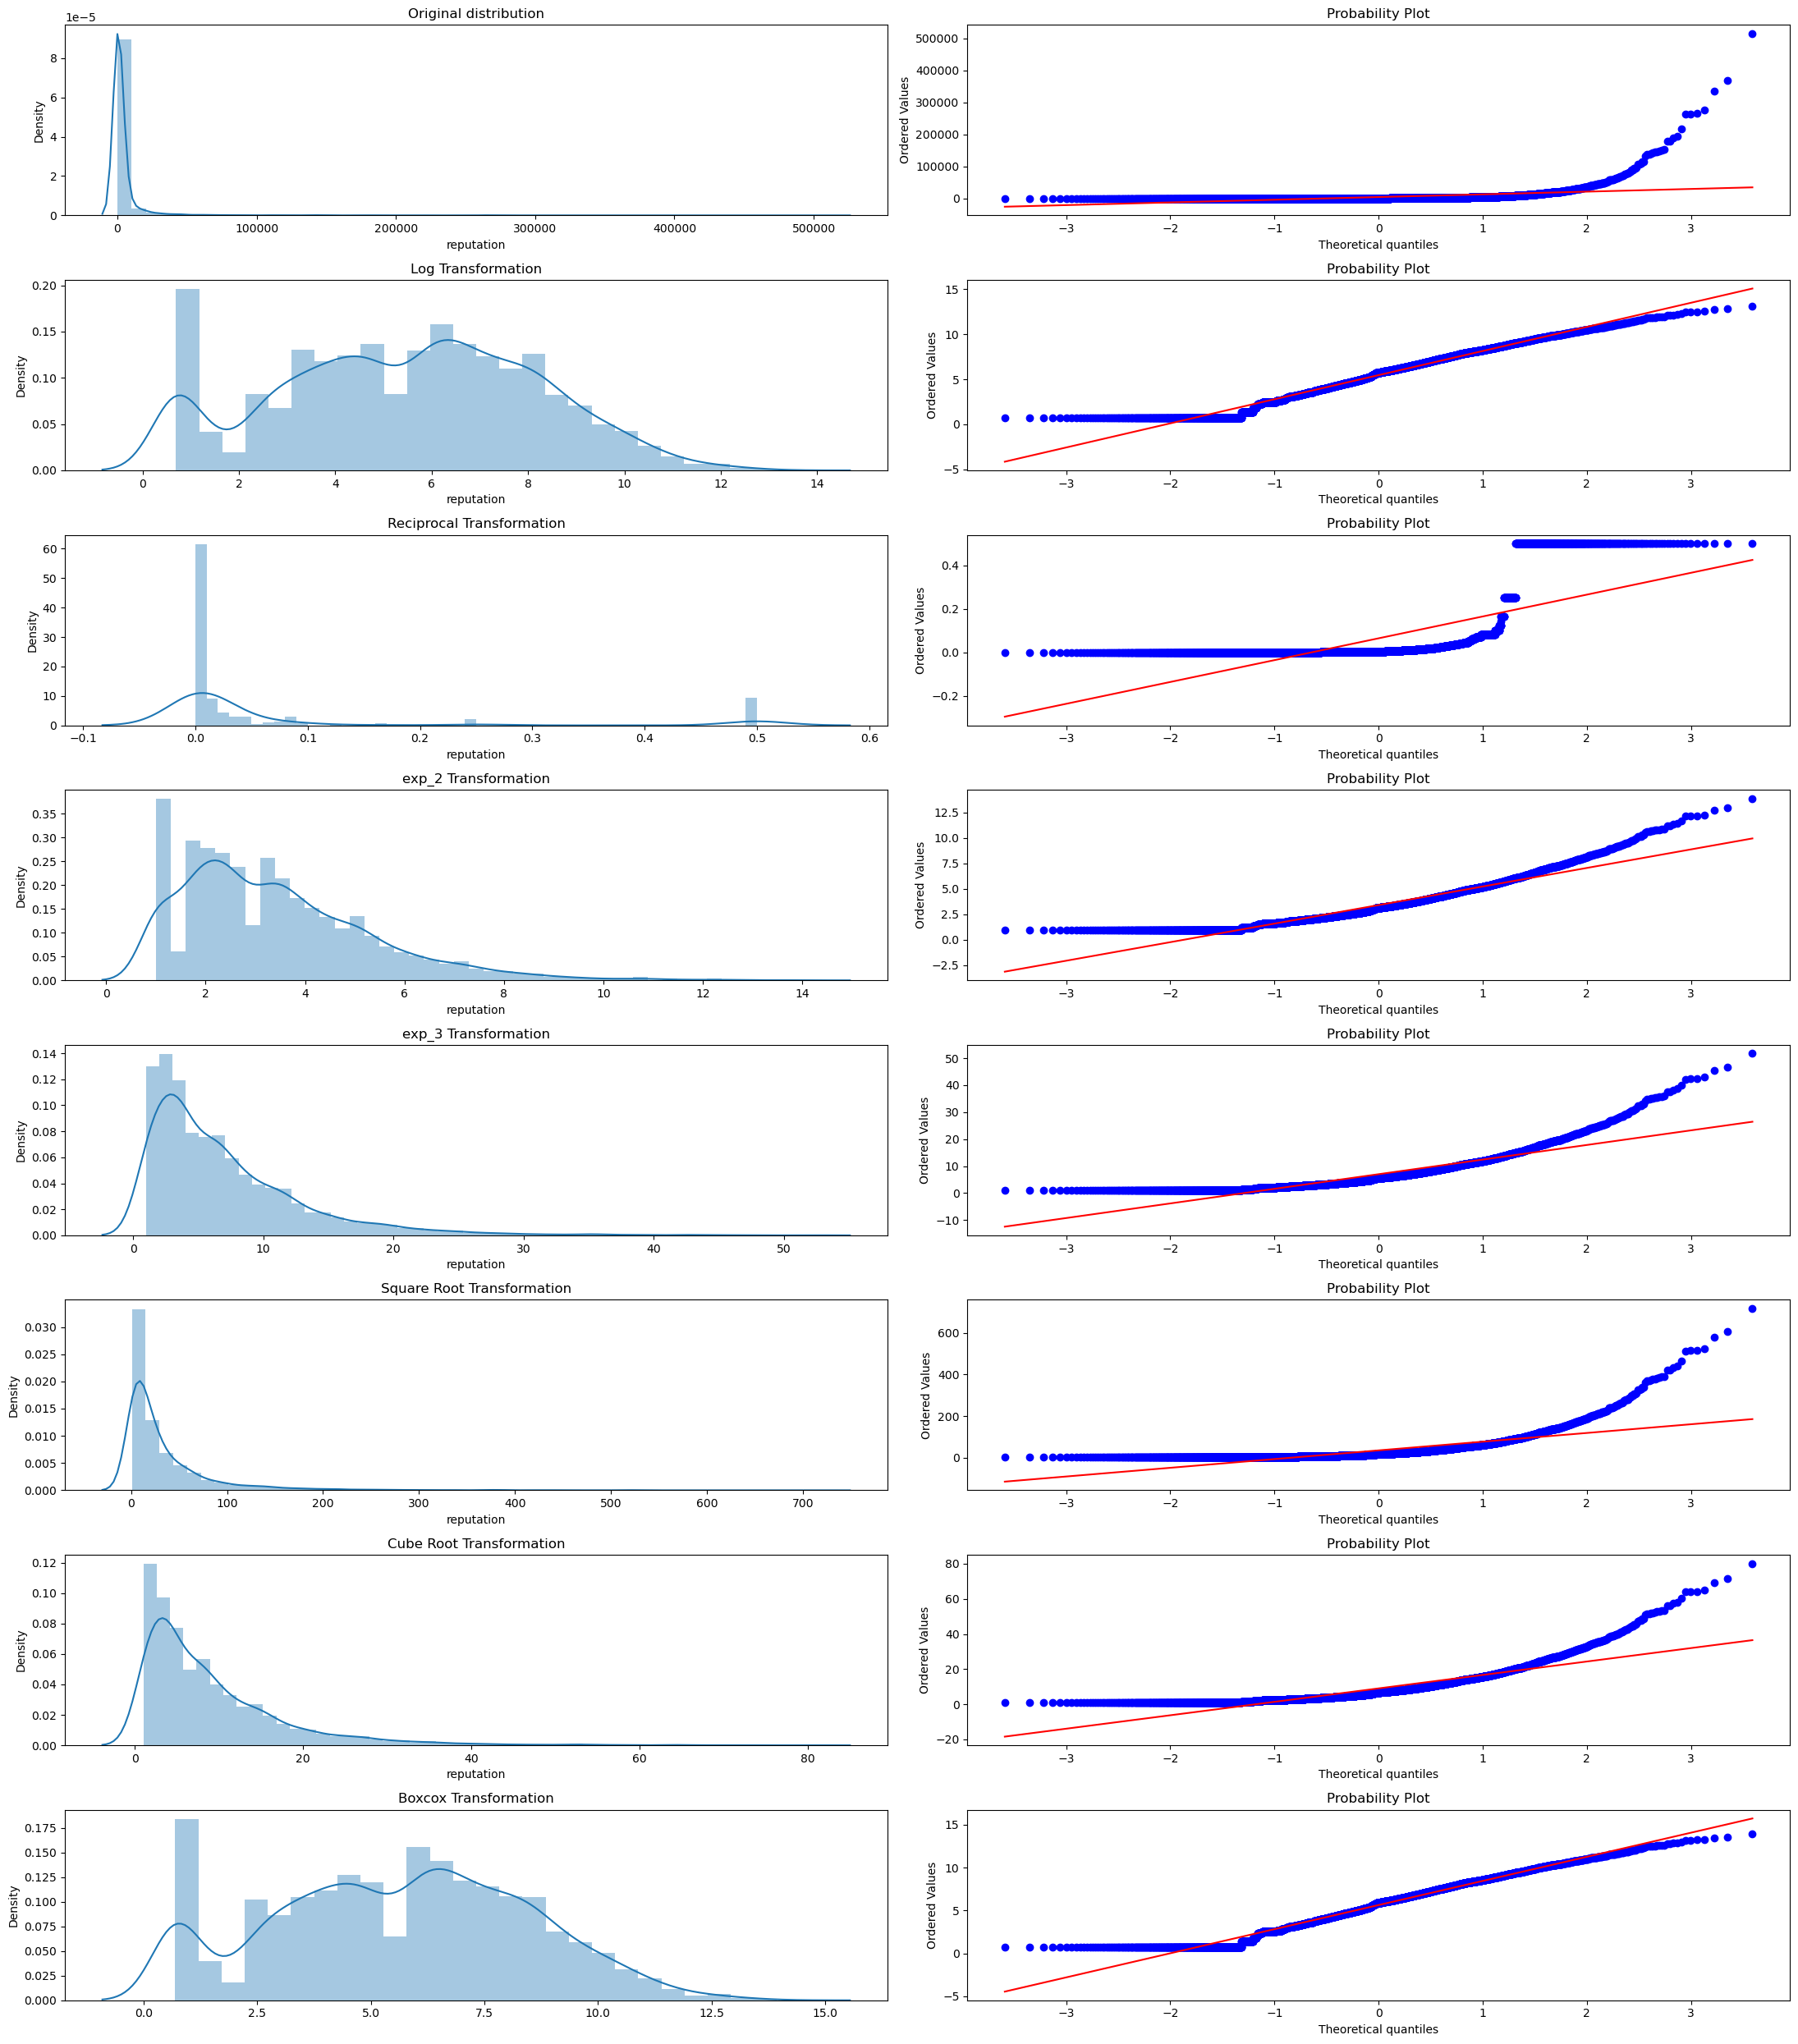

REACHED 

       Transformation      Skew
               Actual 10.820853
                  Log -0.230970
           Reciprocal 31.138537
Exponential power 0.2  1.050417
Exponential power 0.3  1.764409
          Square Root  3.515441
            Cube Root  2.020711
               Boxcox -0.029434

 Best Transformation for  reached : 
 Boxcox = -0.029433690839869513


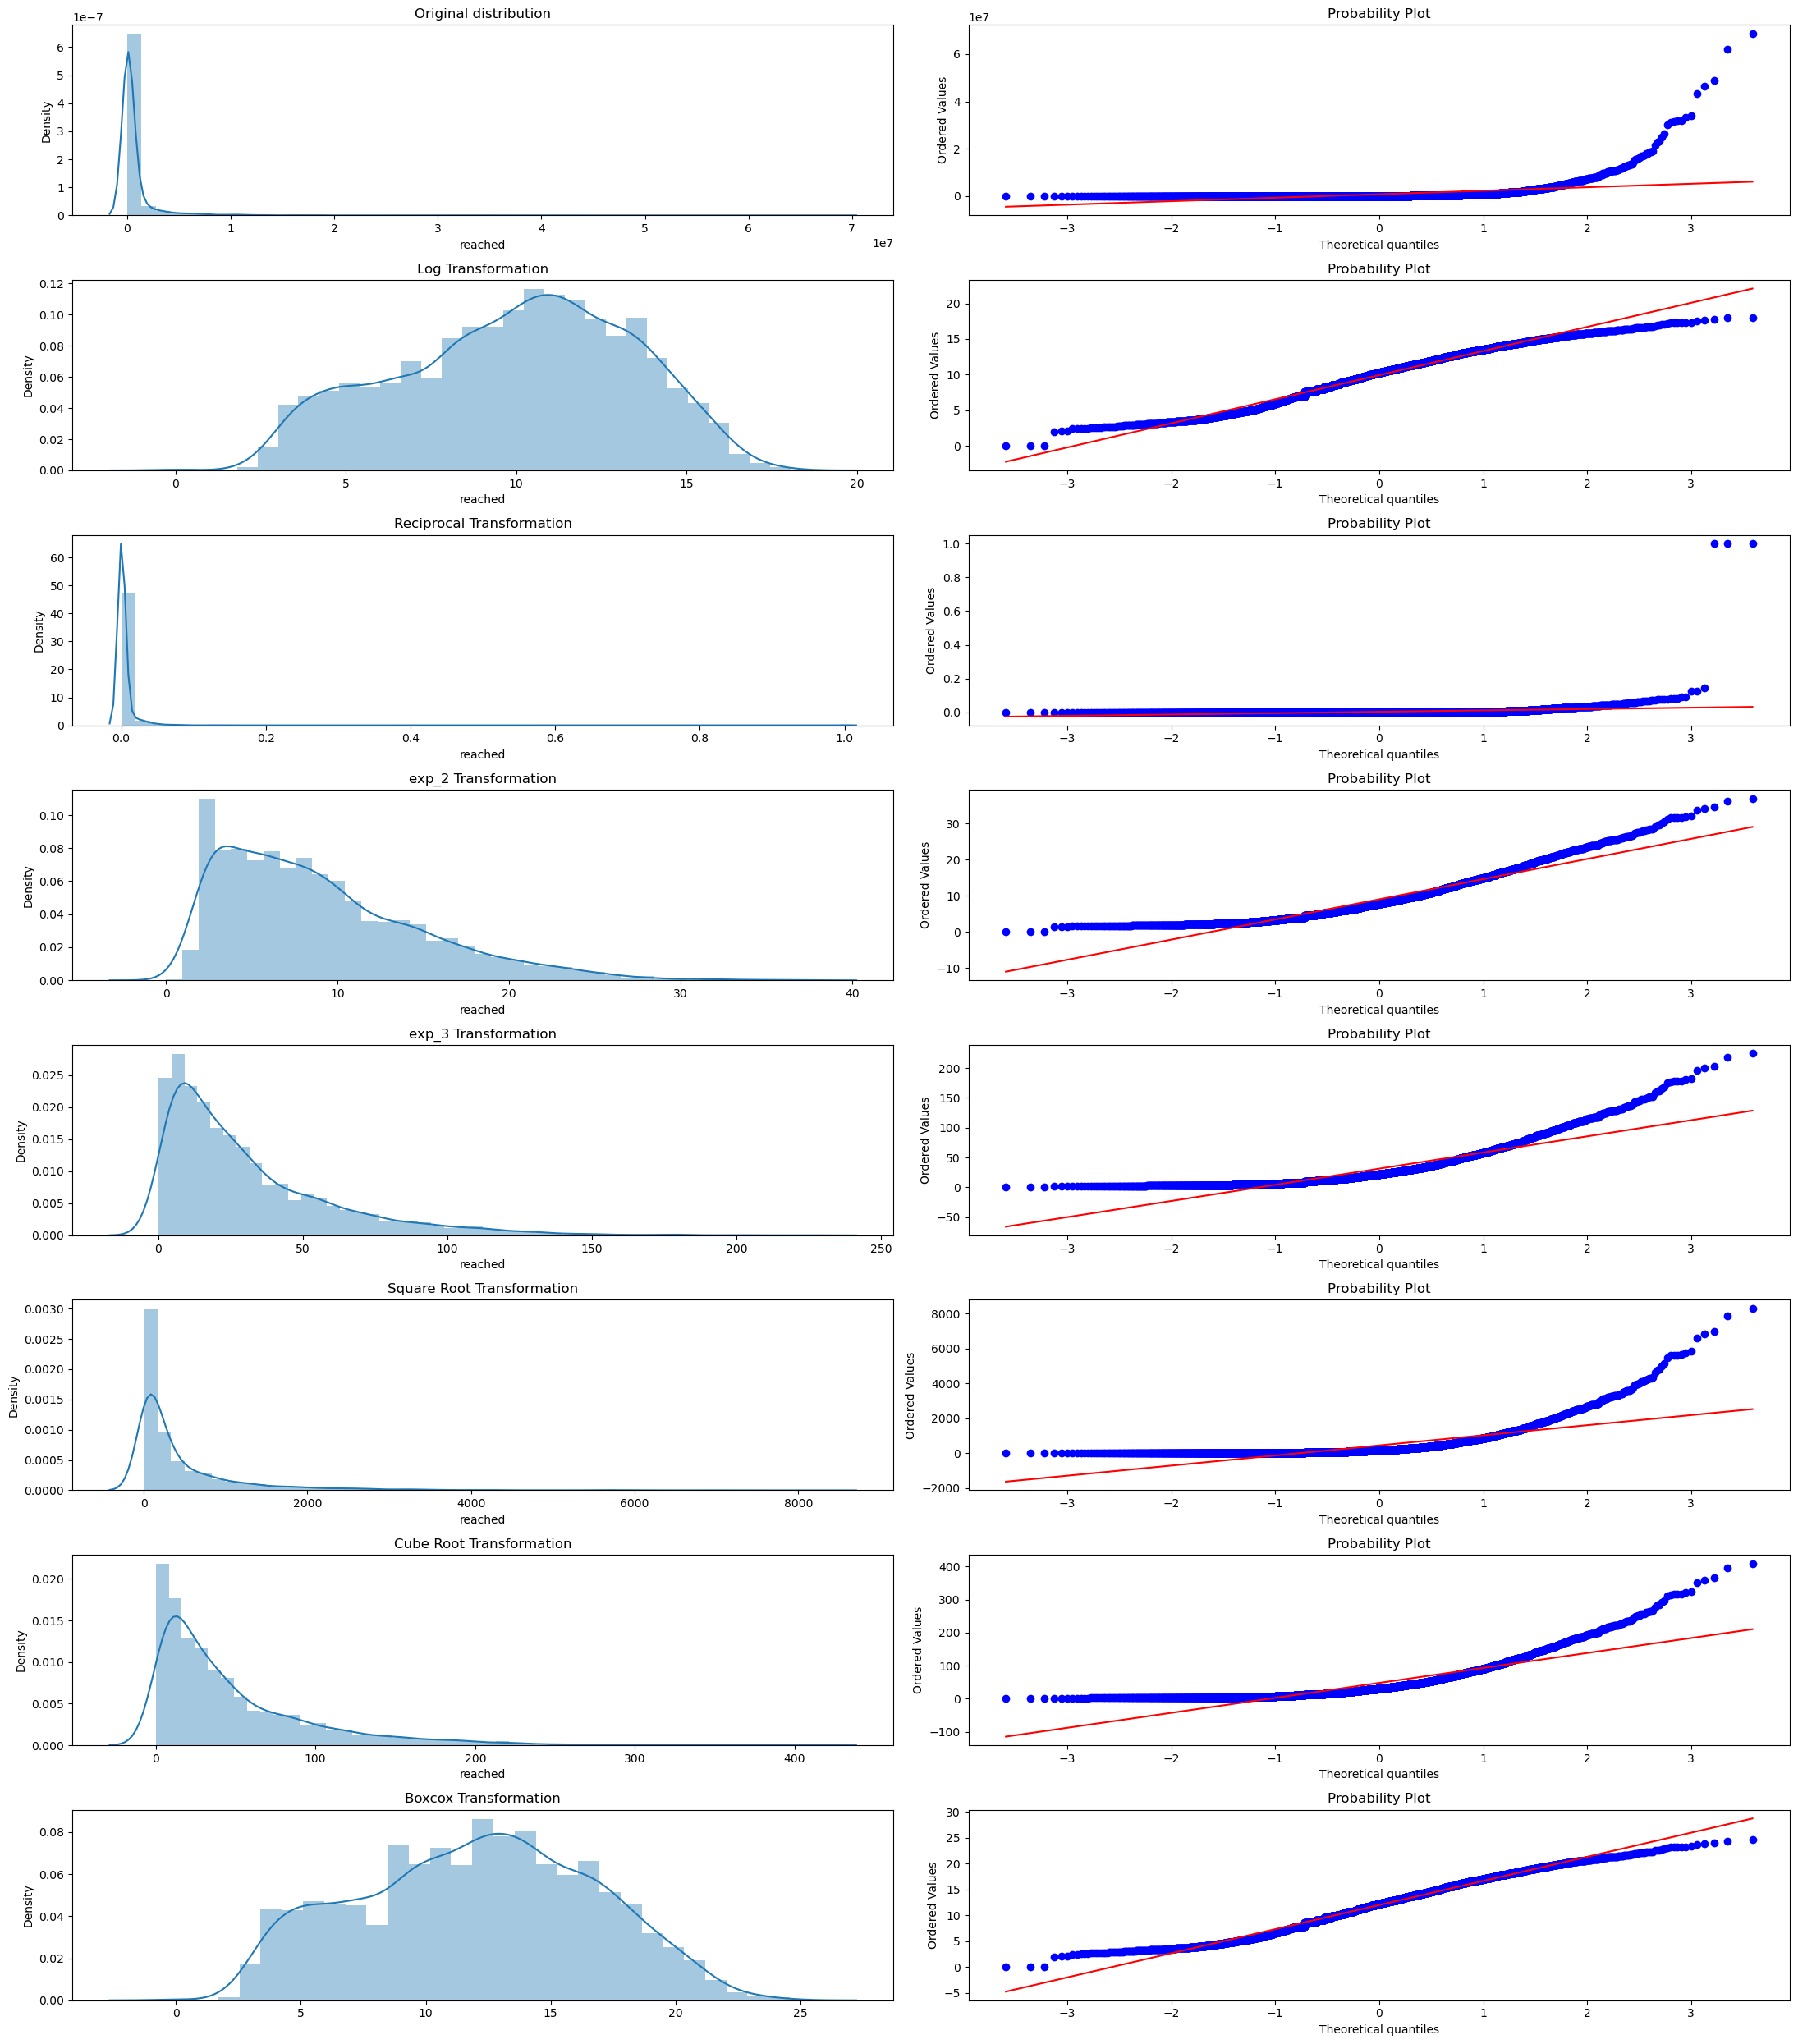

QUESTIONS 

       Transformation     Skew
               Actual 9.074118
                  Log 0.465491
           Reciprocal 1.335738
Exponential power 0.2 0.955248
Exponential power 0.3 1.398109
          Square Root 2.591467
            Cube Root 1.564382
               Boxcox 0.071664

 Best Transformation for  questions : 
 Boxcox = 0.0716636303456541


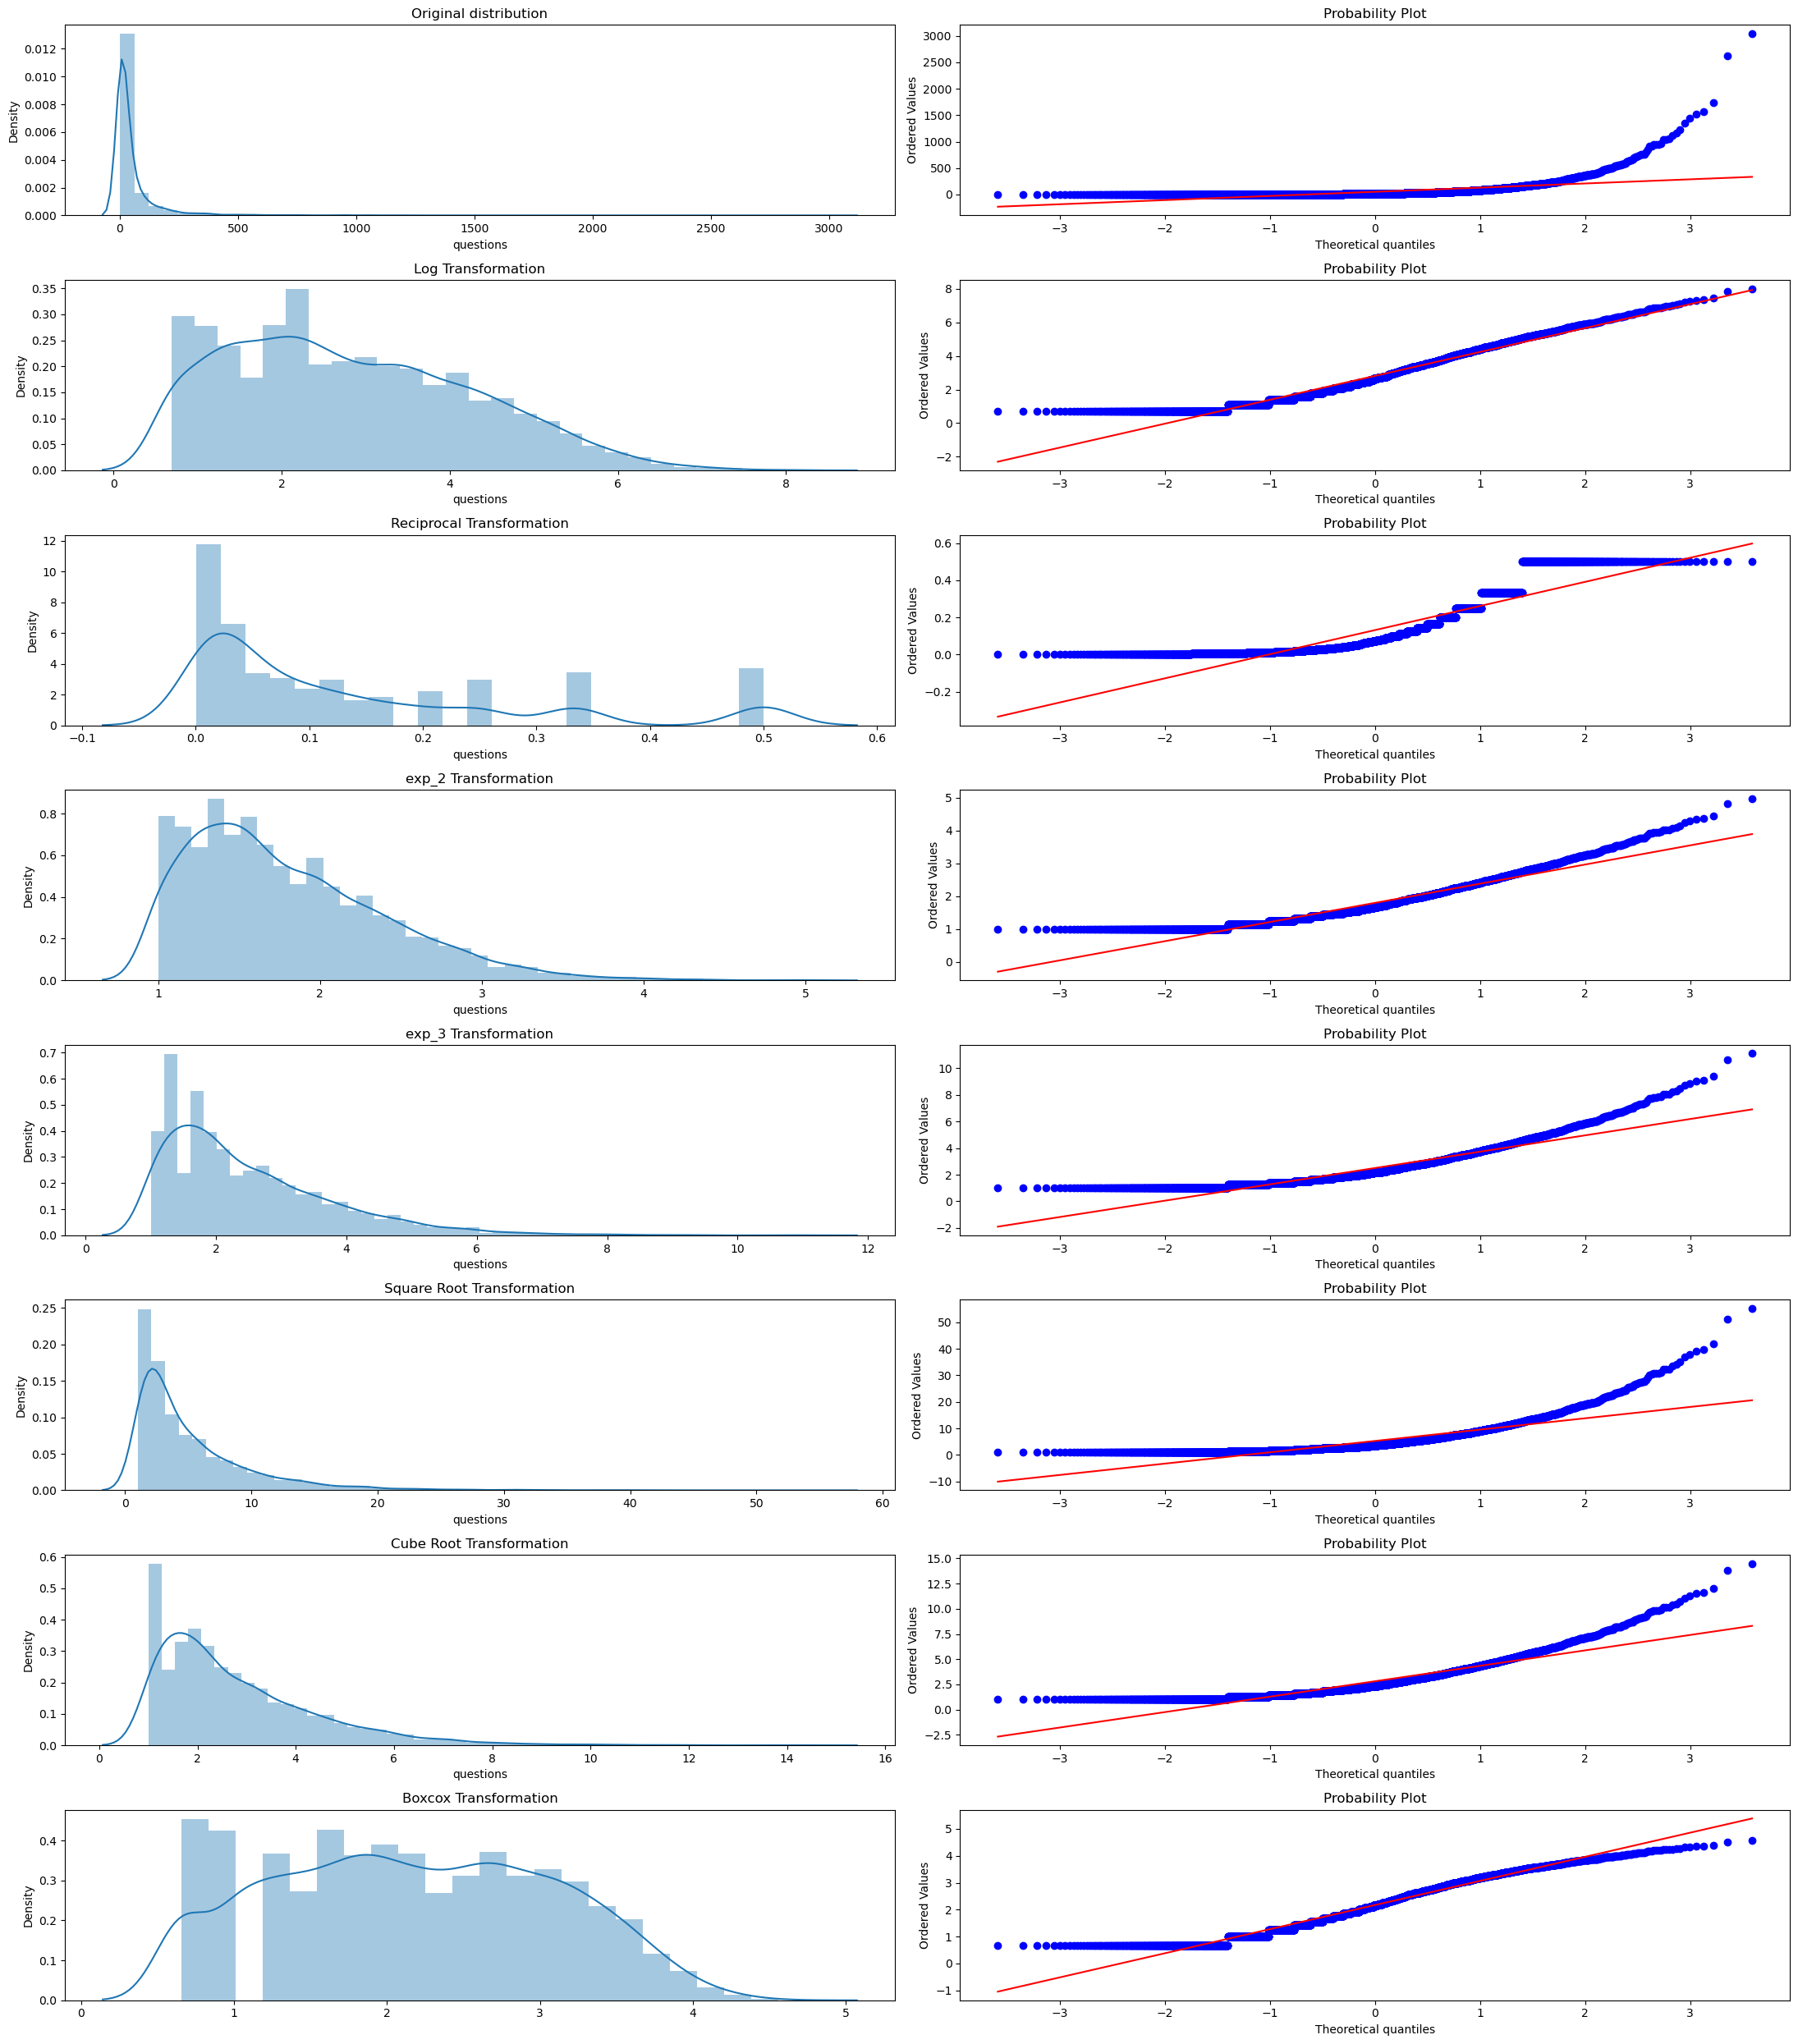

ANSWERS 

       Transformation      Skew
               Actual 26.573866
                  Log  0.713358
           Reciprocal  0.671451
Exponential power 0.2  0.221974
Exponential power 0.3  1.397348
          Square Root  4.841857
            Cube Root  1.841116
               Boxcox  0.152533

 Best Transformation for  answers : 
 Boxcox = 0.15253302988824663


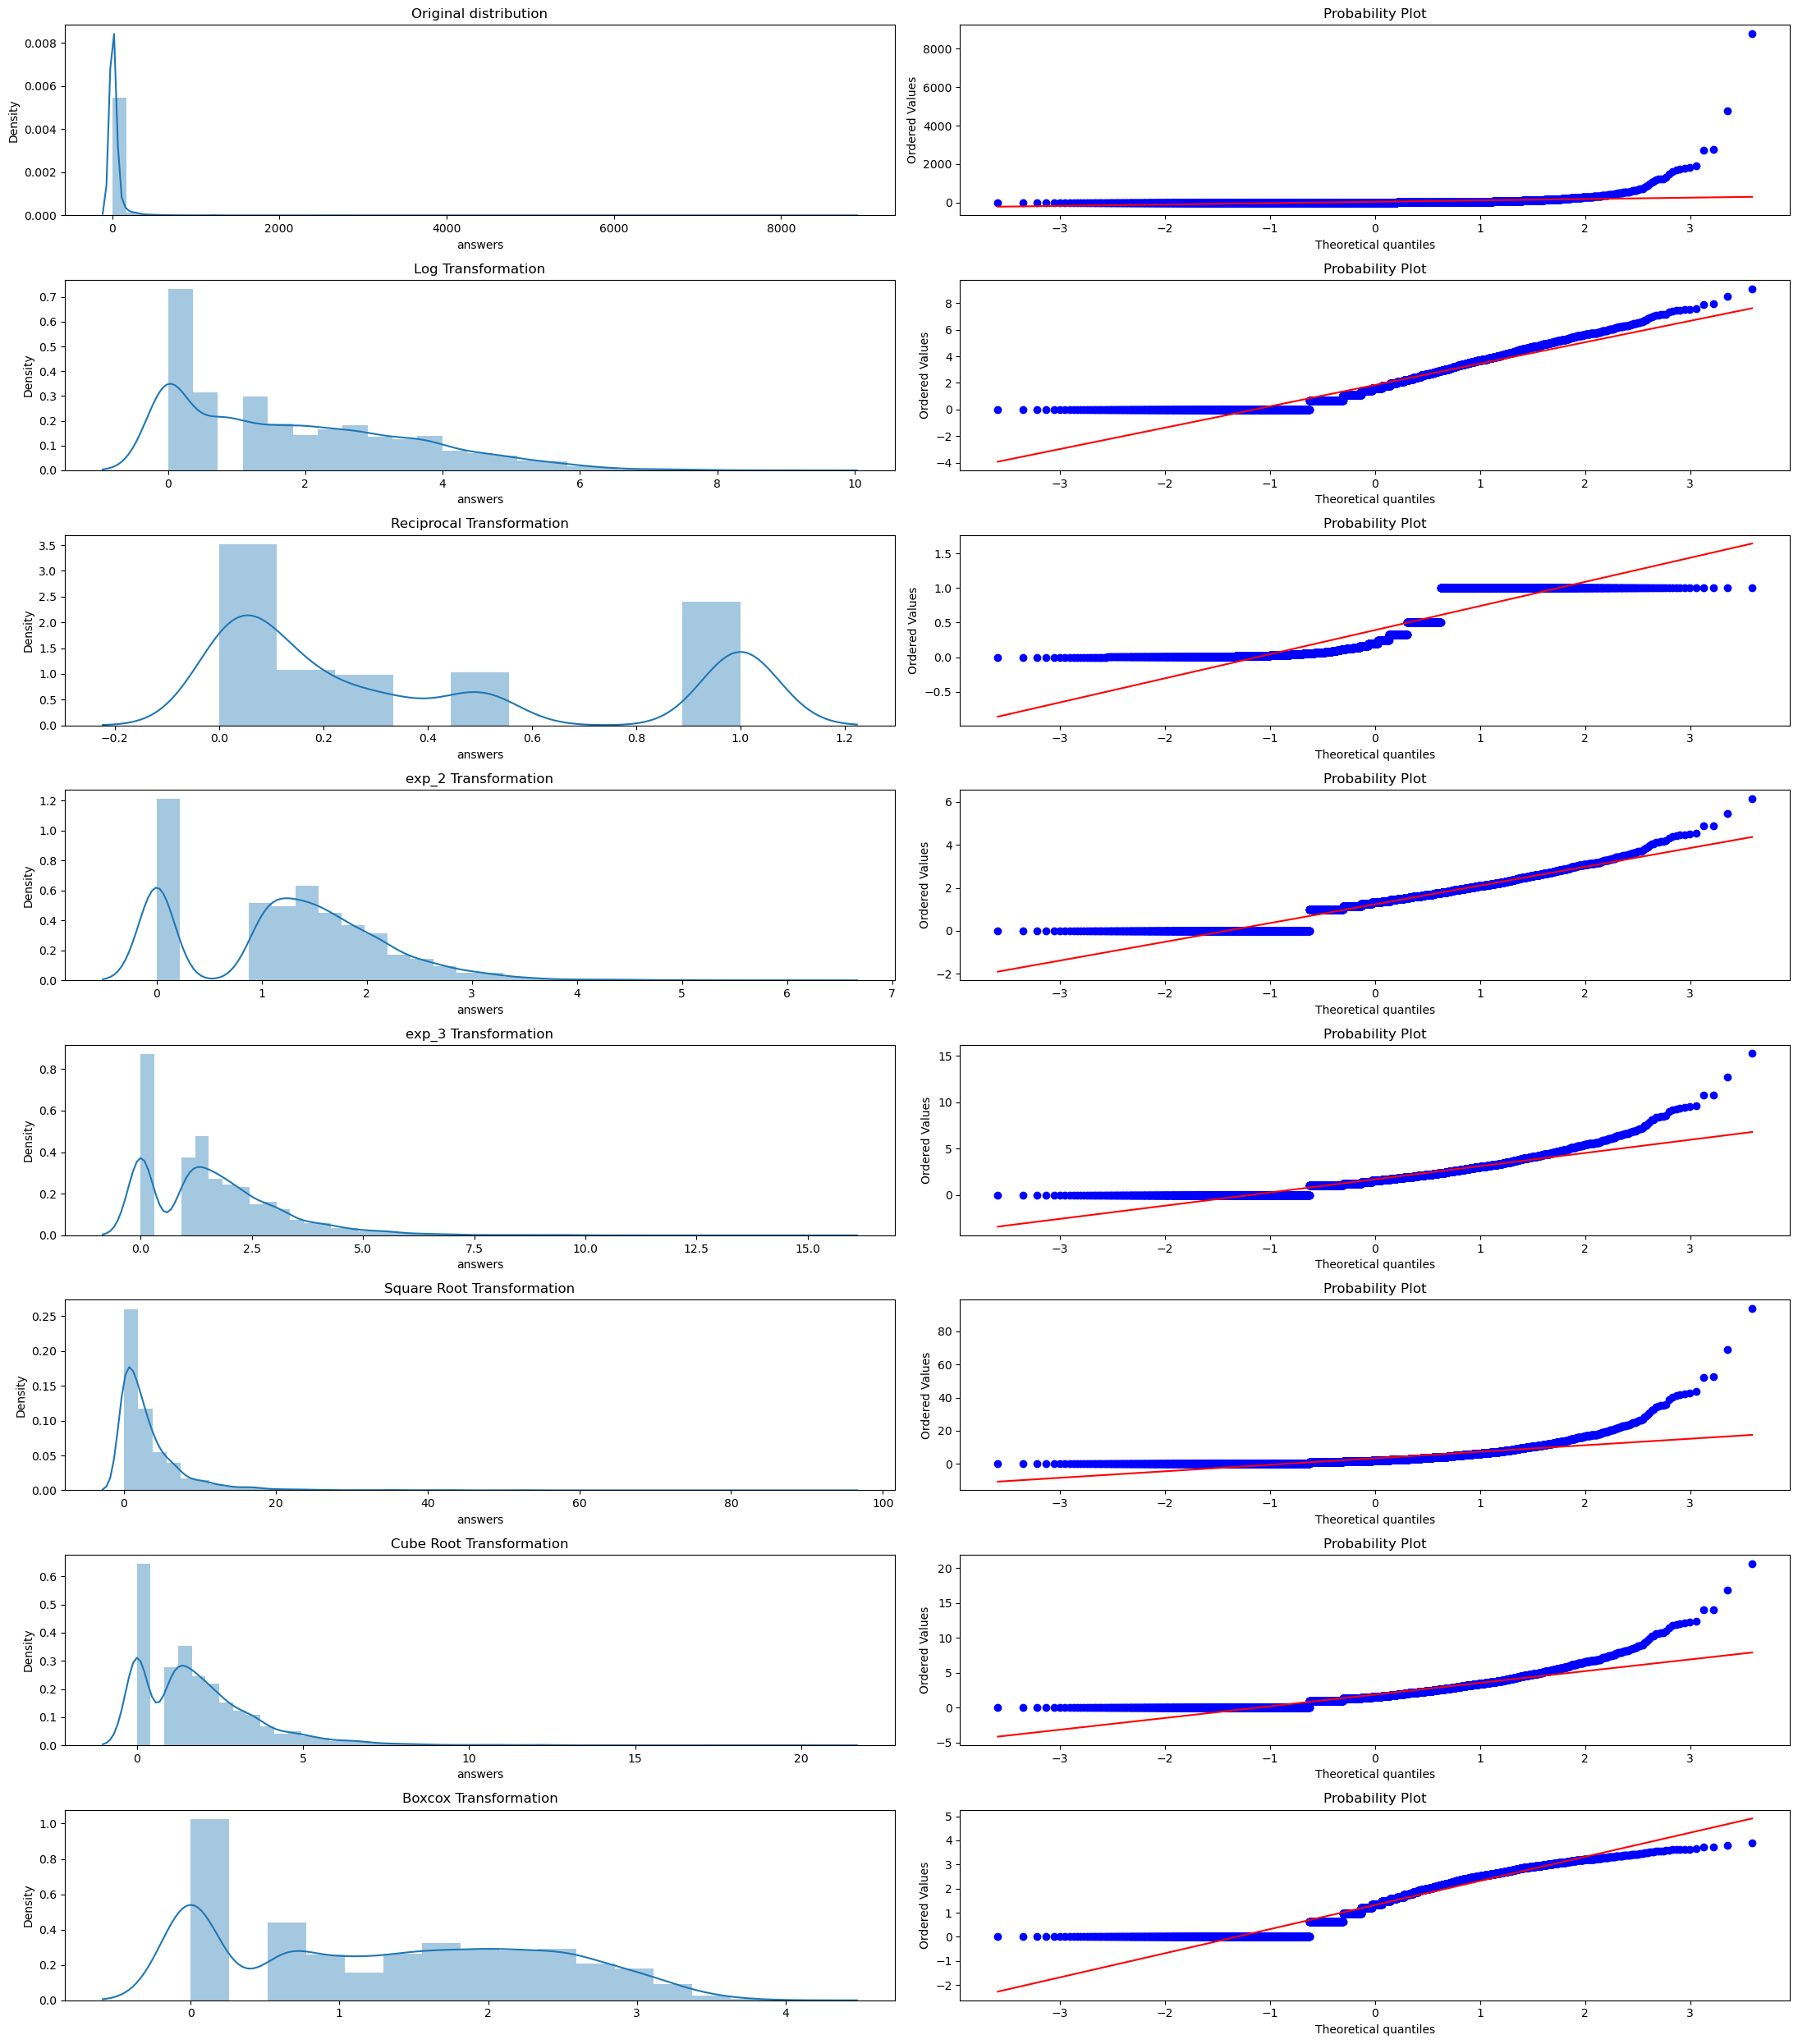

POSTS_EDITED 

       Transformation      Skew
               Actual 34.218237
                  Log  2.535173
           Reciprocal -1.230840
Exponential power 0.2  1.930292
Exponential power 0.3  3.454463
          Square Root  9.889626
            Cube Root  4.186512
               Boxcox  1.151866

 Best Transformation for  posts_edited : 
 Boxcox = 1.151865682008149


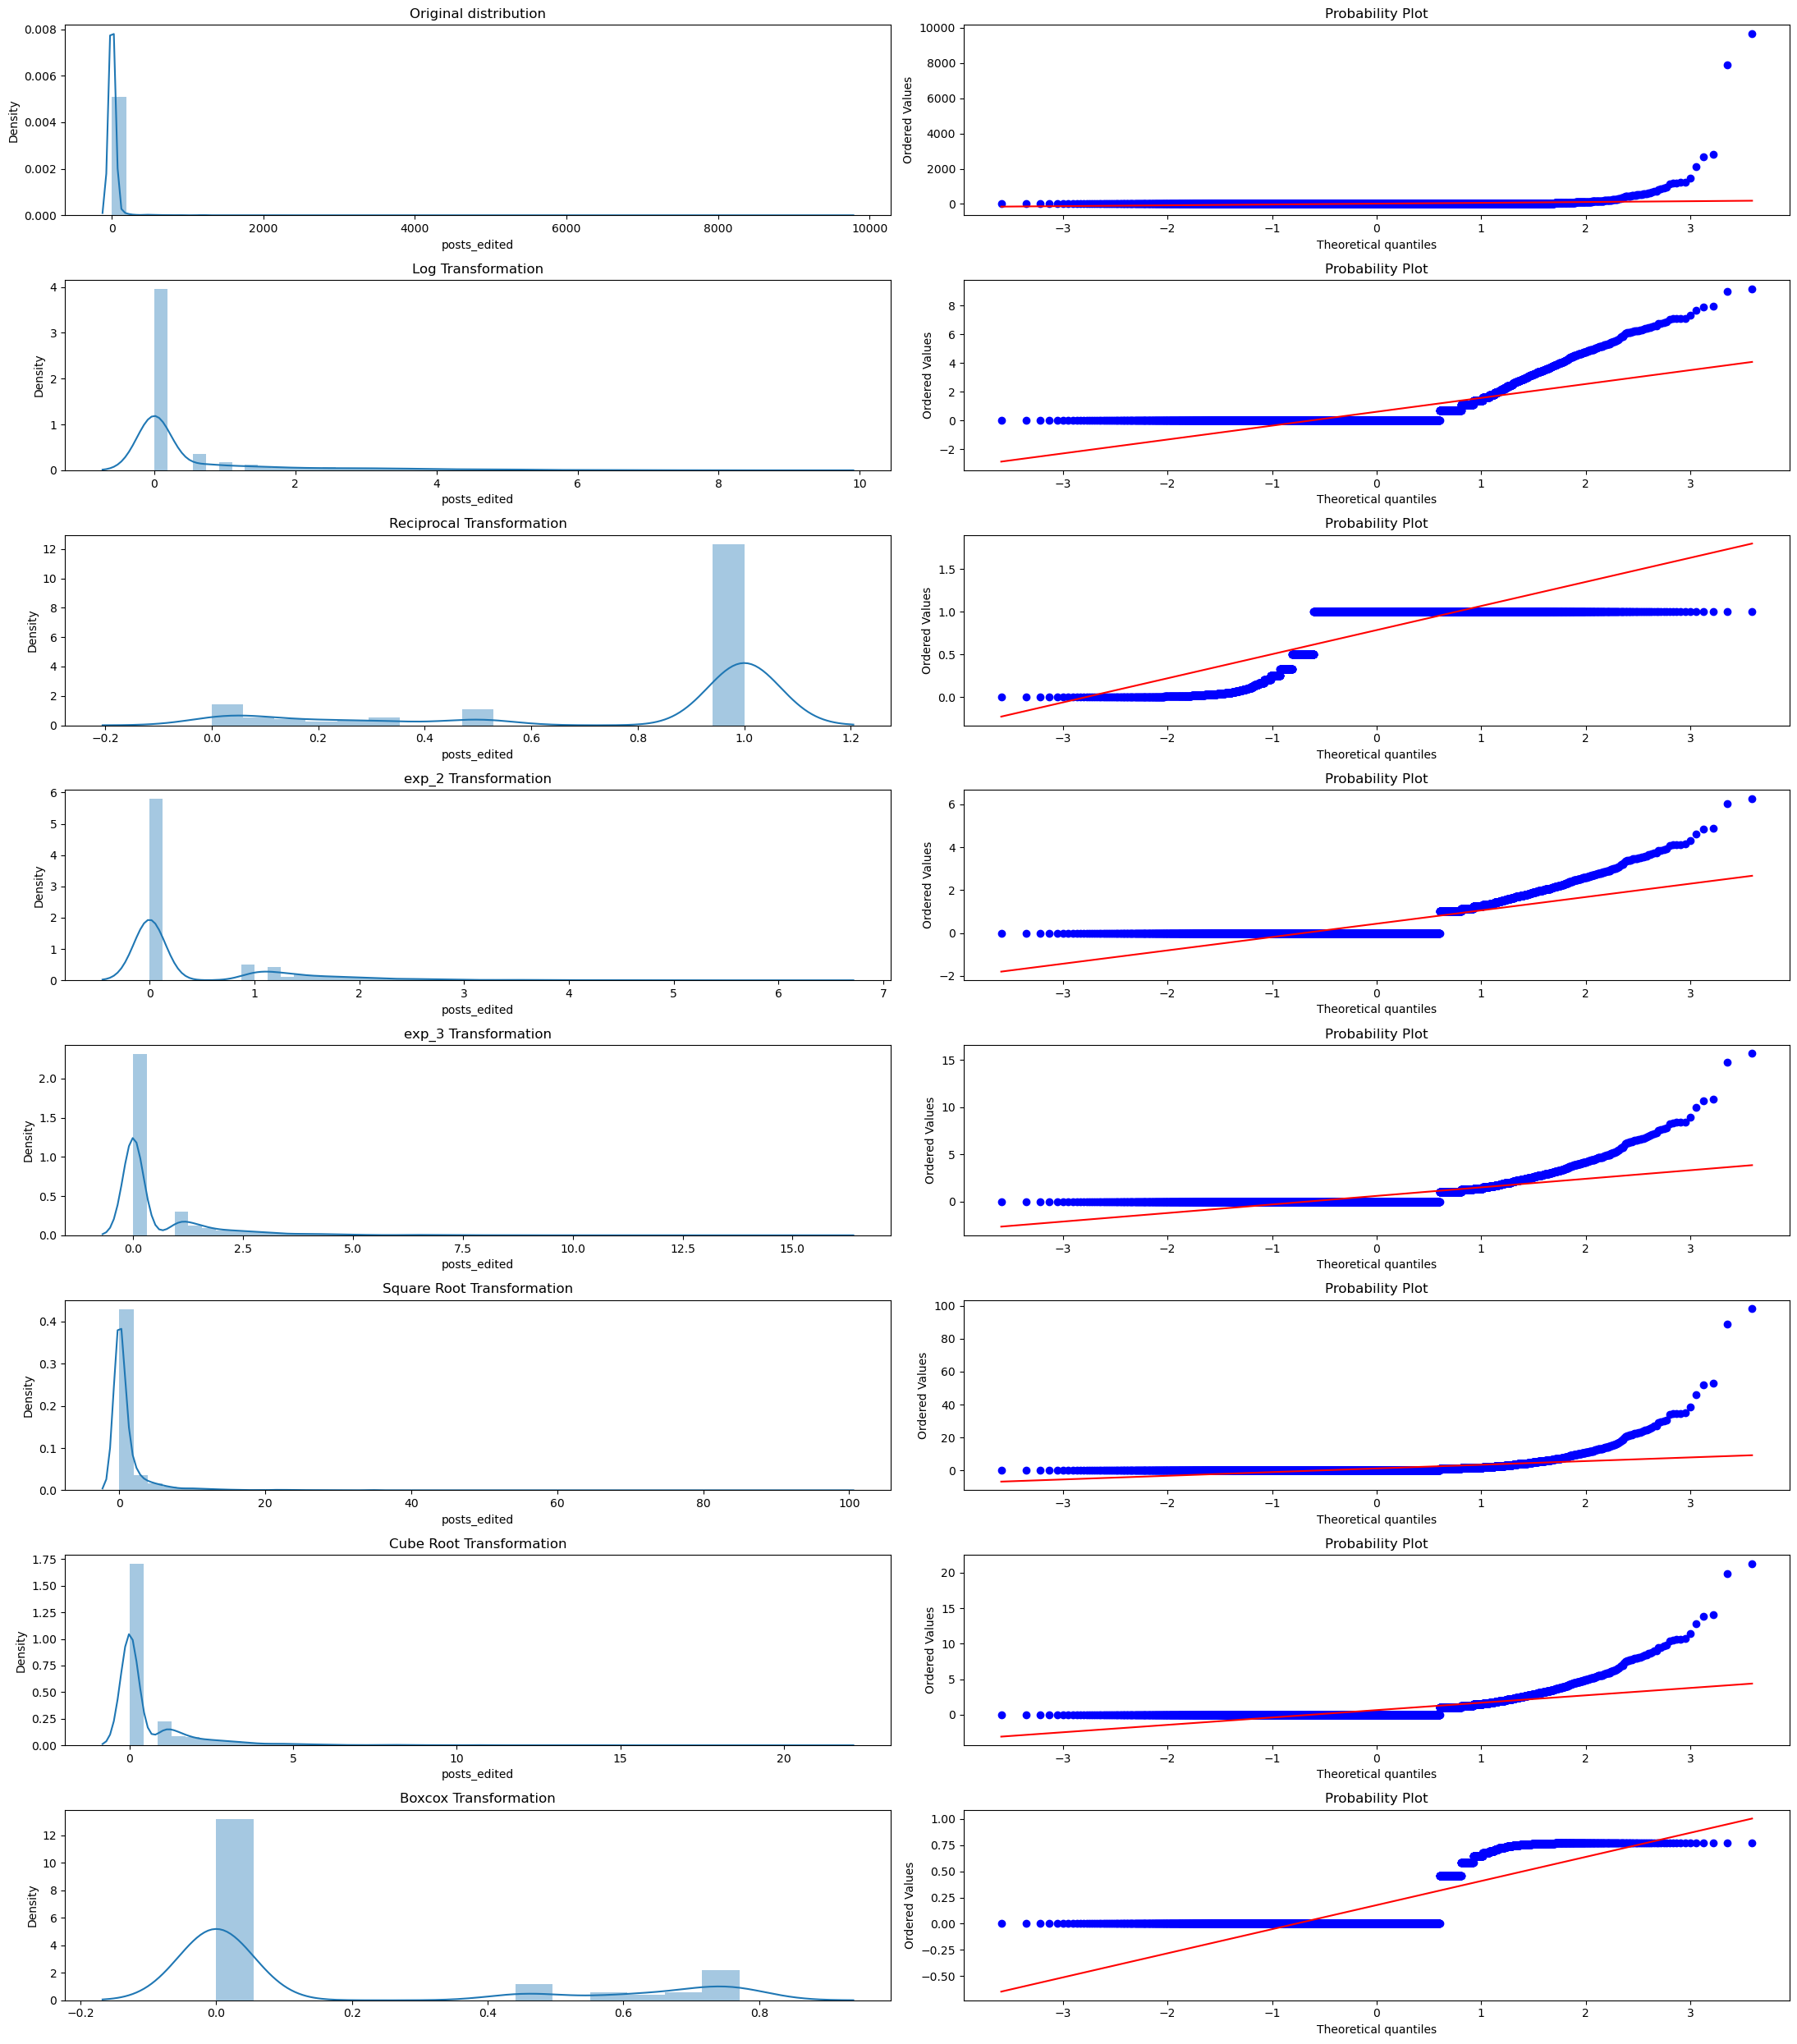

HELPFUL_TAGS 

       Transformation      Skew
               Actual 61.029496
                  Log  3.380379
           Reciprocal -1.510850
Exponential power 0.2  2.521877
Exponential power 0.3  6.084259
          Square Root 27.562372
            Cube Root  8.281358
               Boxcox  1.318180

 Best Transformation for  helpful_tags : 
 Boxcox = 1.3181800965629282


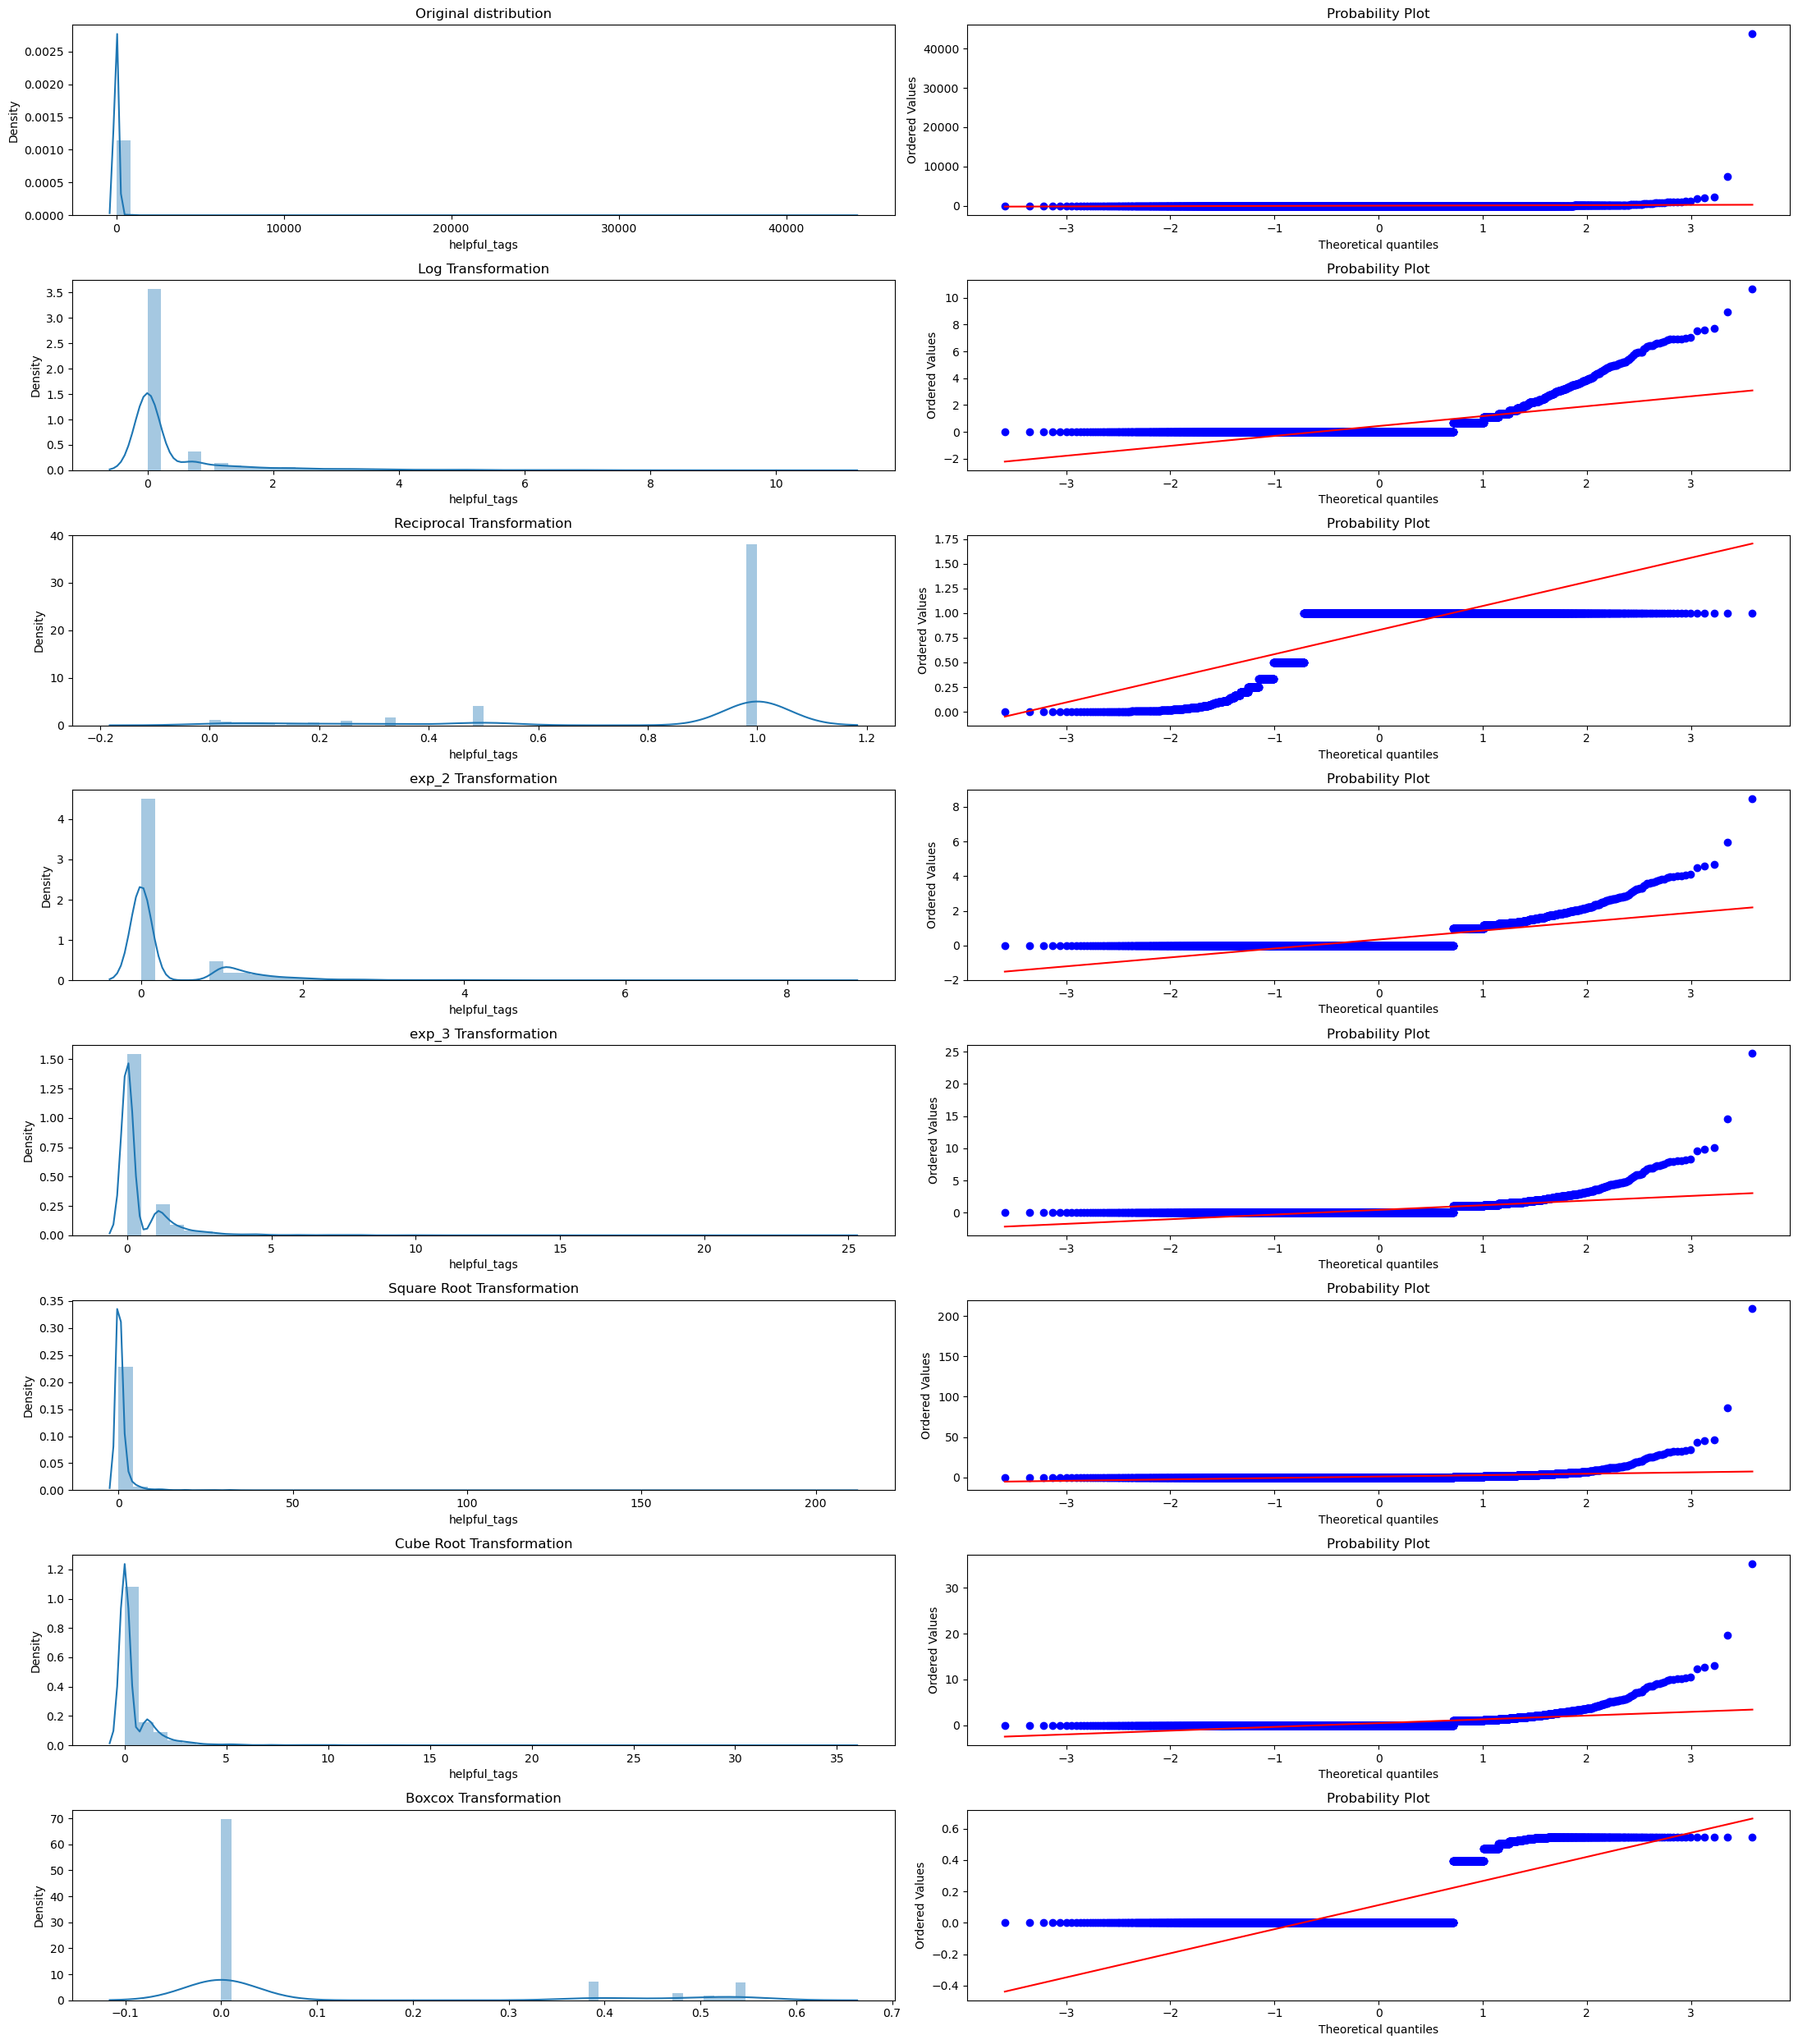

VOTES_CAST 

       Transformation      Skew
               Actual 34.619448
                  Log  0.276115
           Reciprocal  1.000444
Exponential power 0.2  0.425132
Exponential power 0.3  1.419462
          Square Root  4.283960
            Cube Root  1.767122
               Boxcox  0.069744

 Best Transformation for  votes_cast : 
 Boxcox = 0.06974376937970103


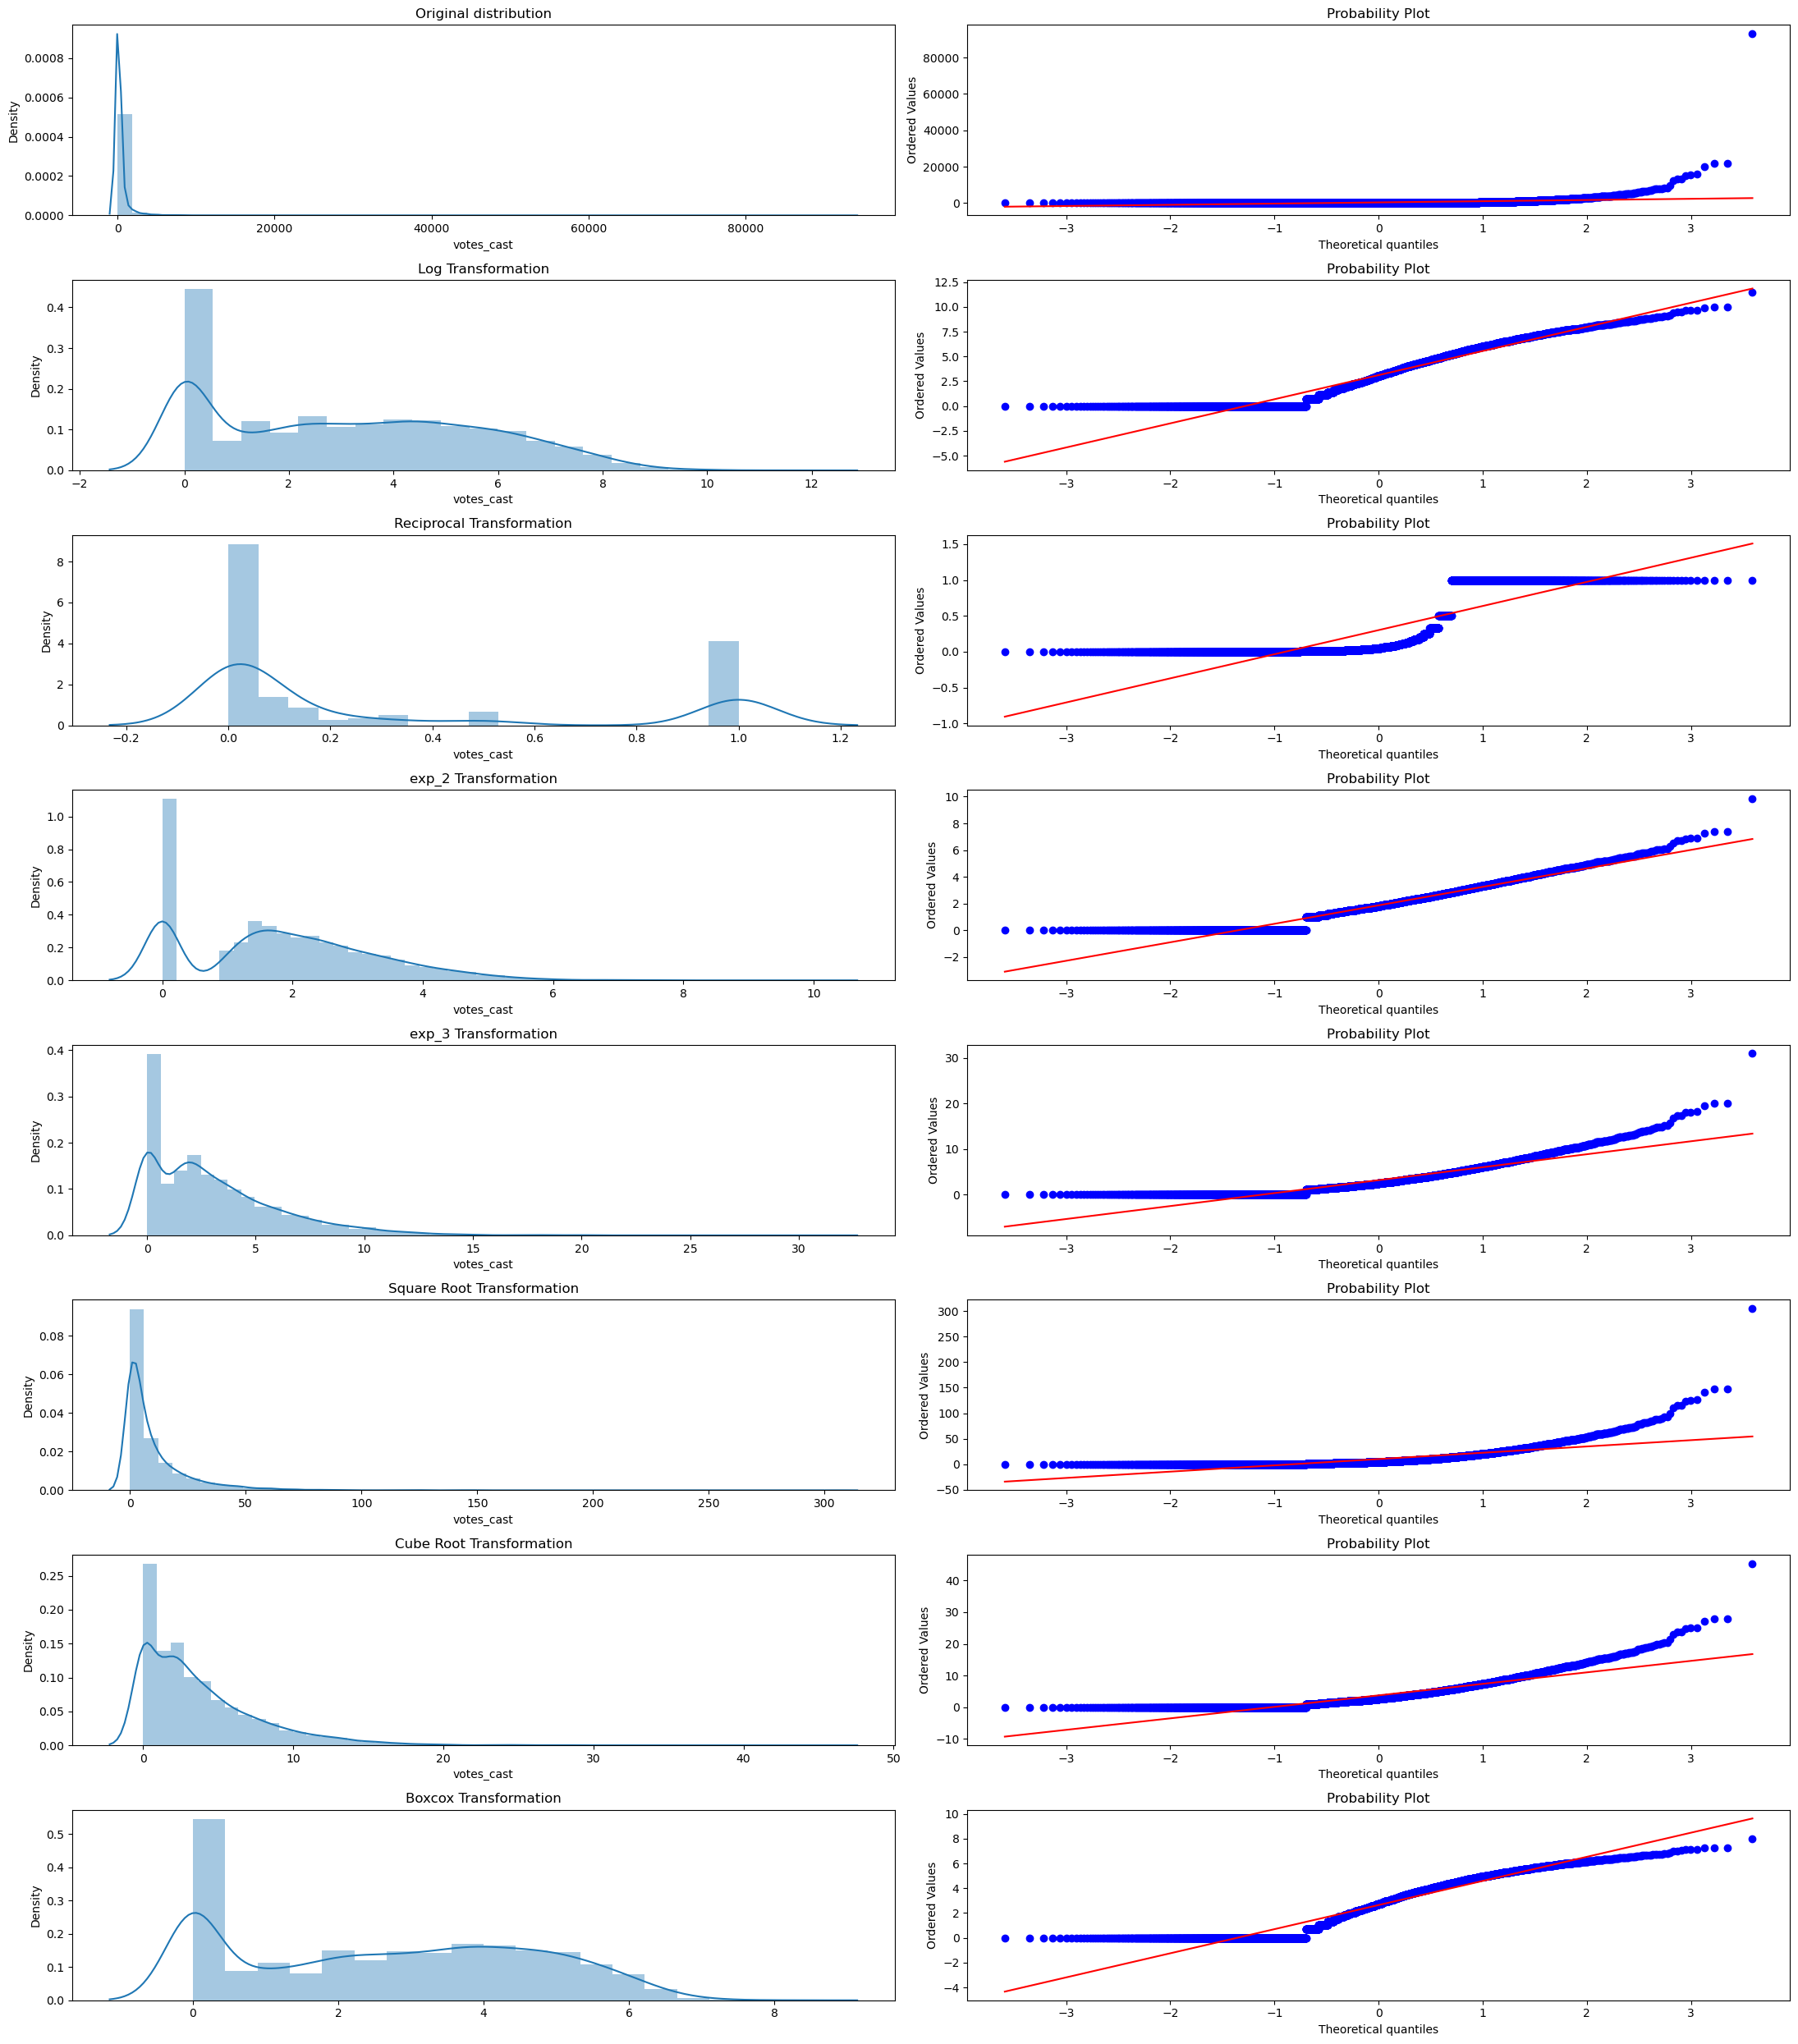

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual  7.381539
                  Log -0.026513
           Reciprocal  4.266480
Exponential power 0.2  0.009046
Exponential power 0.3  1.111697
          Square Root  2.592836
            Cube Root  1.381325
               Boxcox  0.000677

 Best Transformation for  weighted_badge_score : 
 Boxcox = 0.0006766599477907438


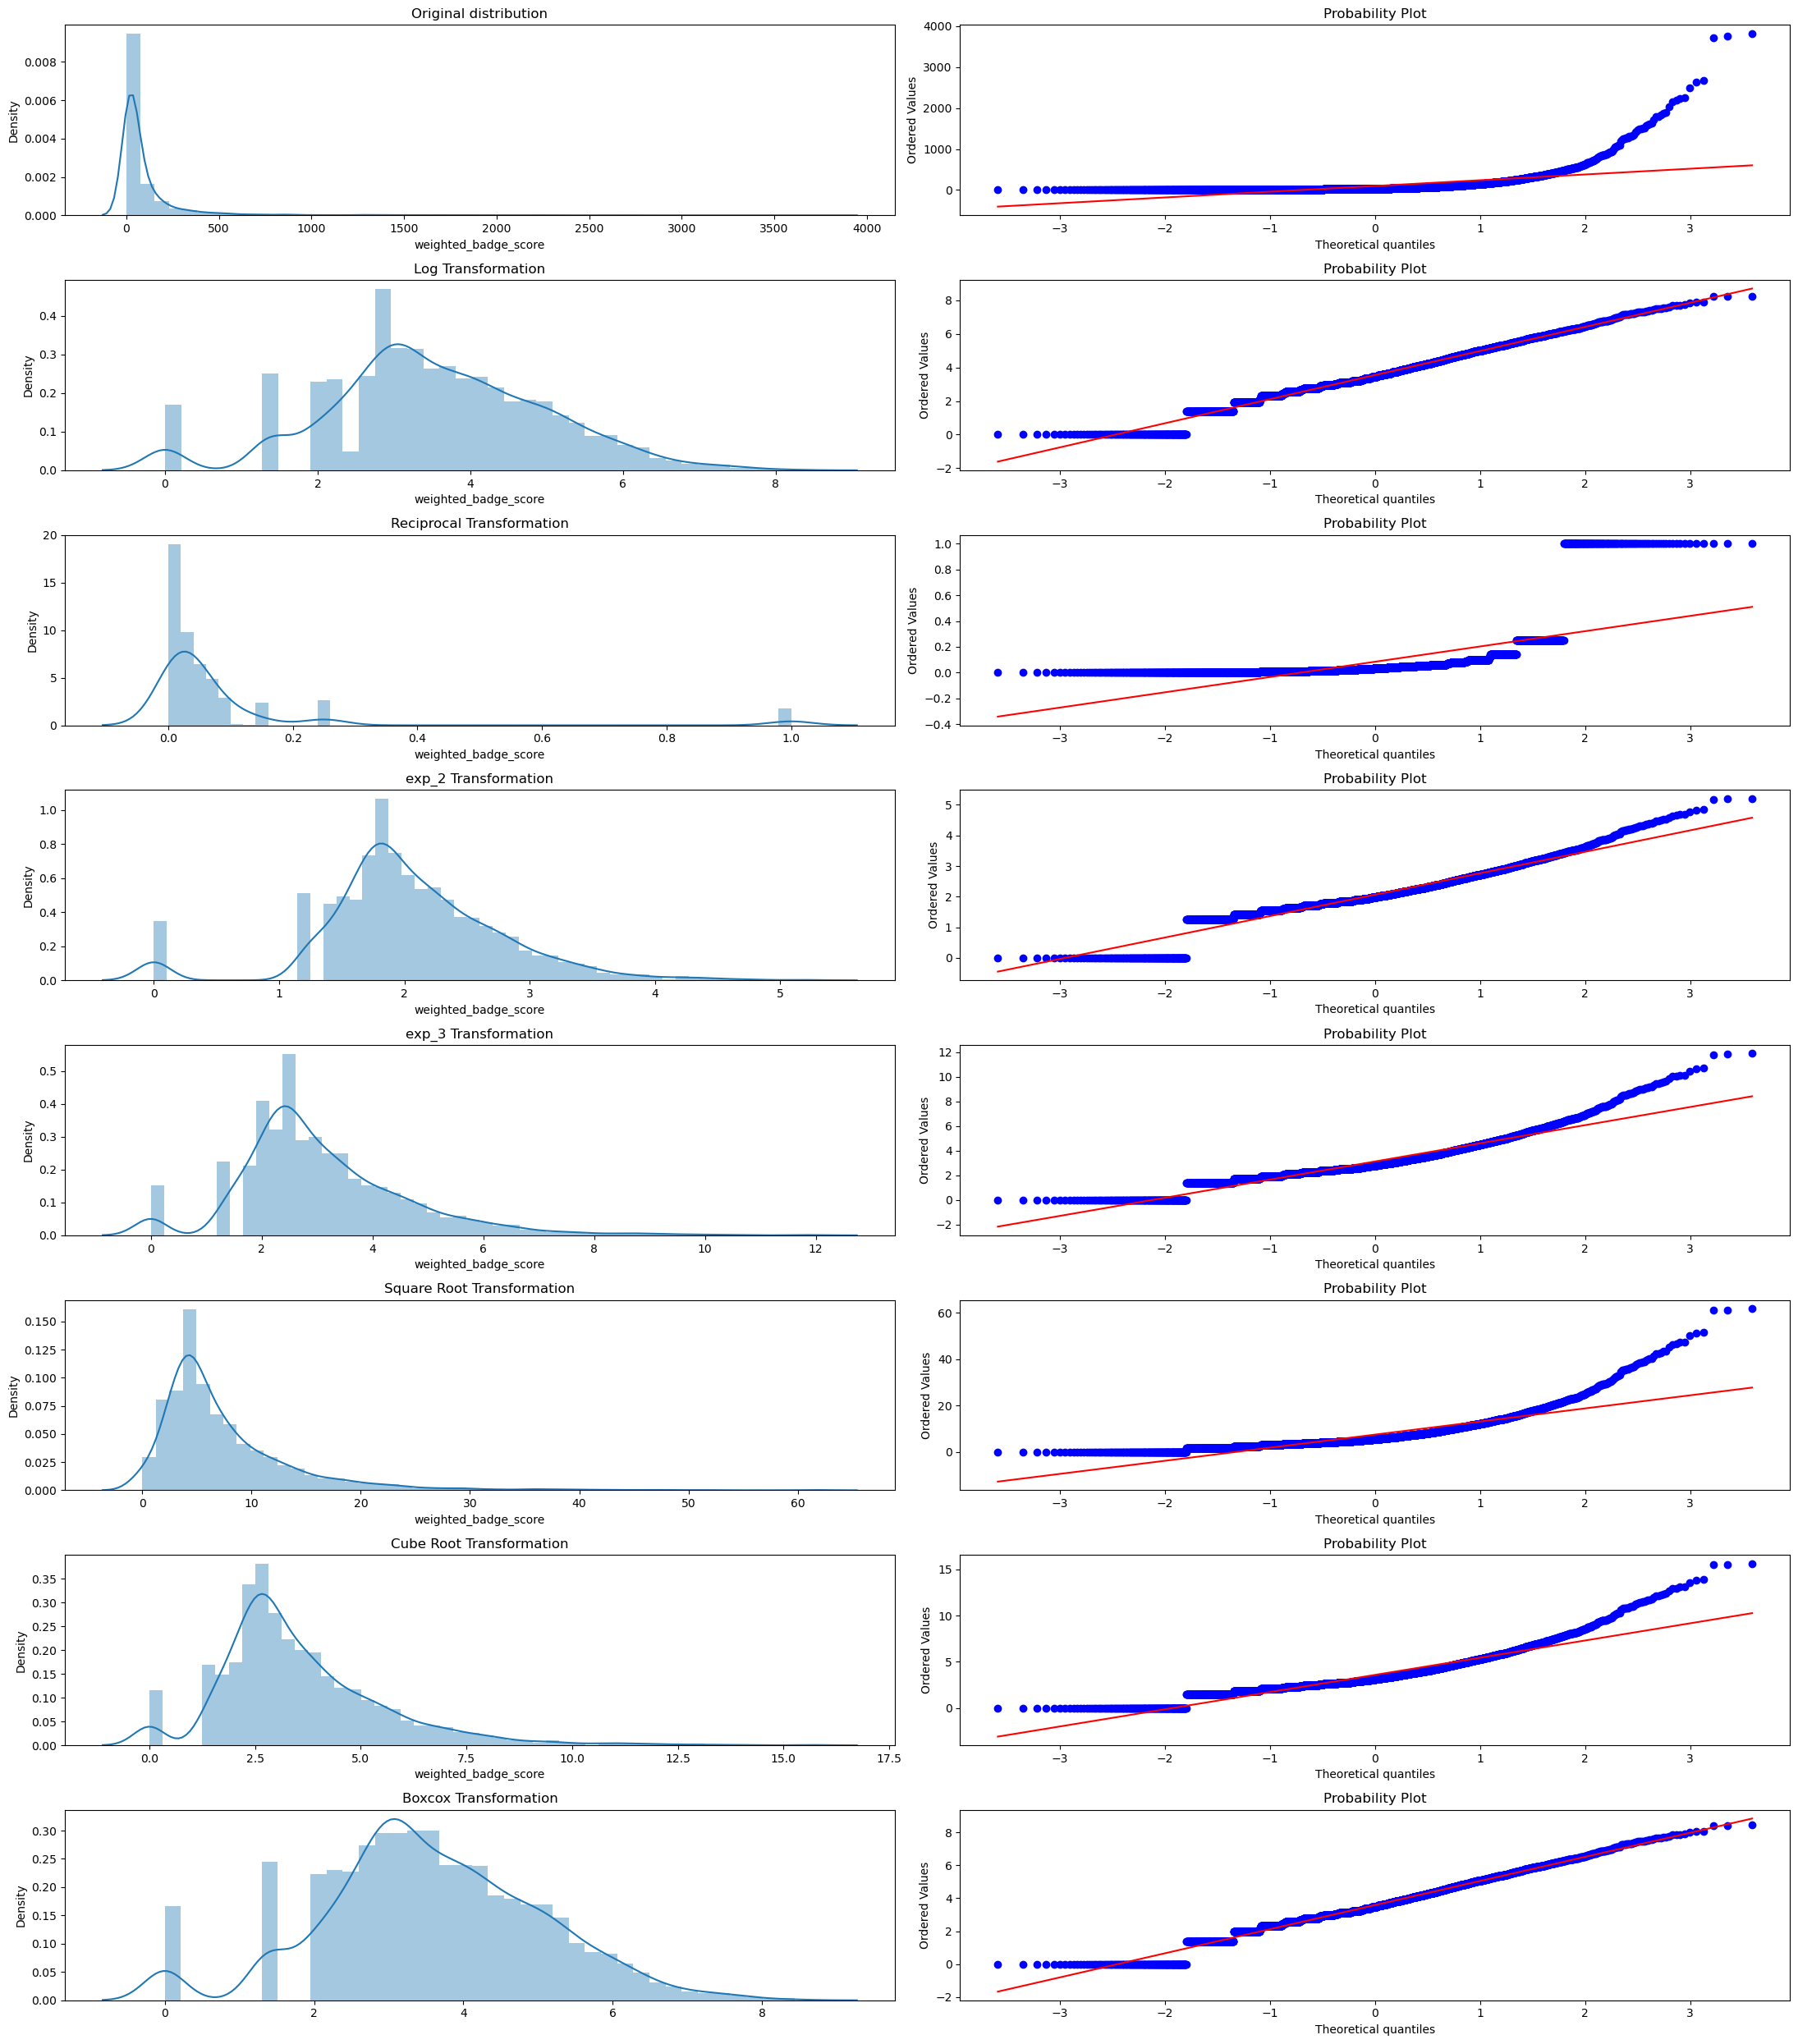

QA_RATIO 

       Transformation      Skew
               Actual 22.951284
                  Log  2.714216
           Reciprocal -0.983566
Exponential power 0.2  0.085366
Exponential power 0.3  1.331753
          Square Root  5.060477
            Cube Root  1.825826
               Boxcox  0.554847

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.08536619590646306


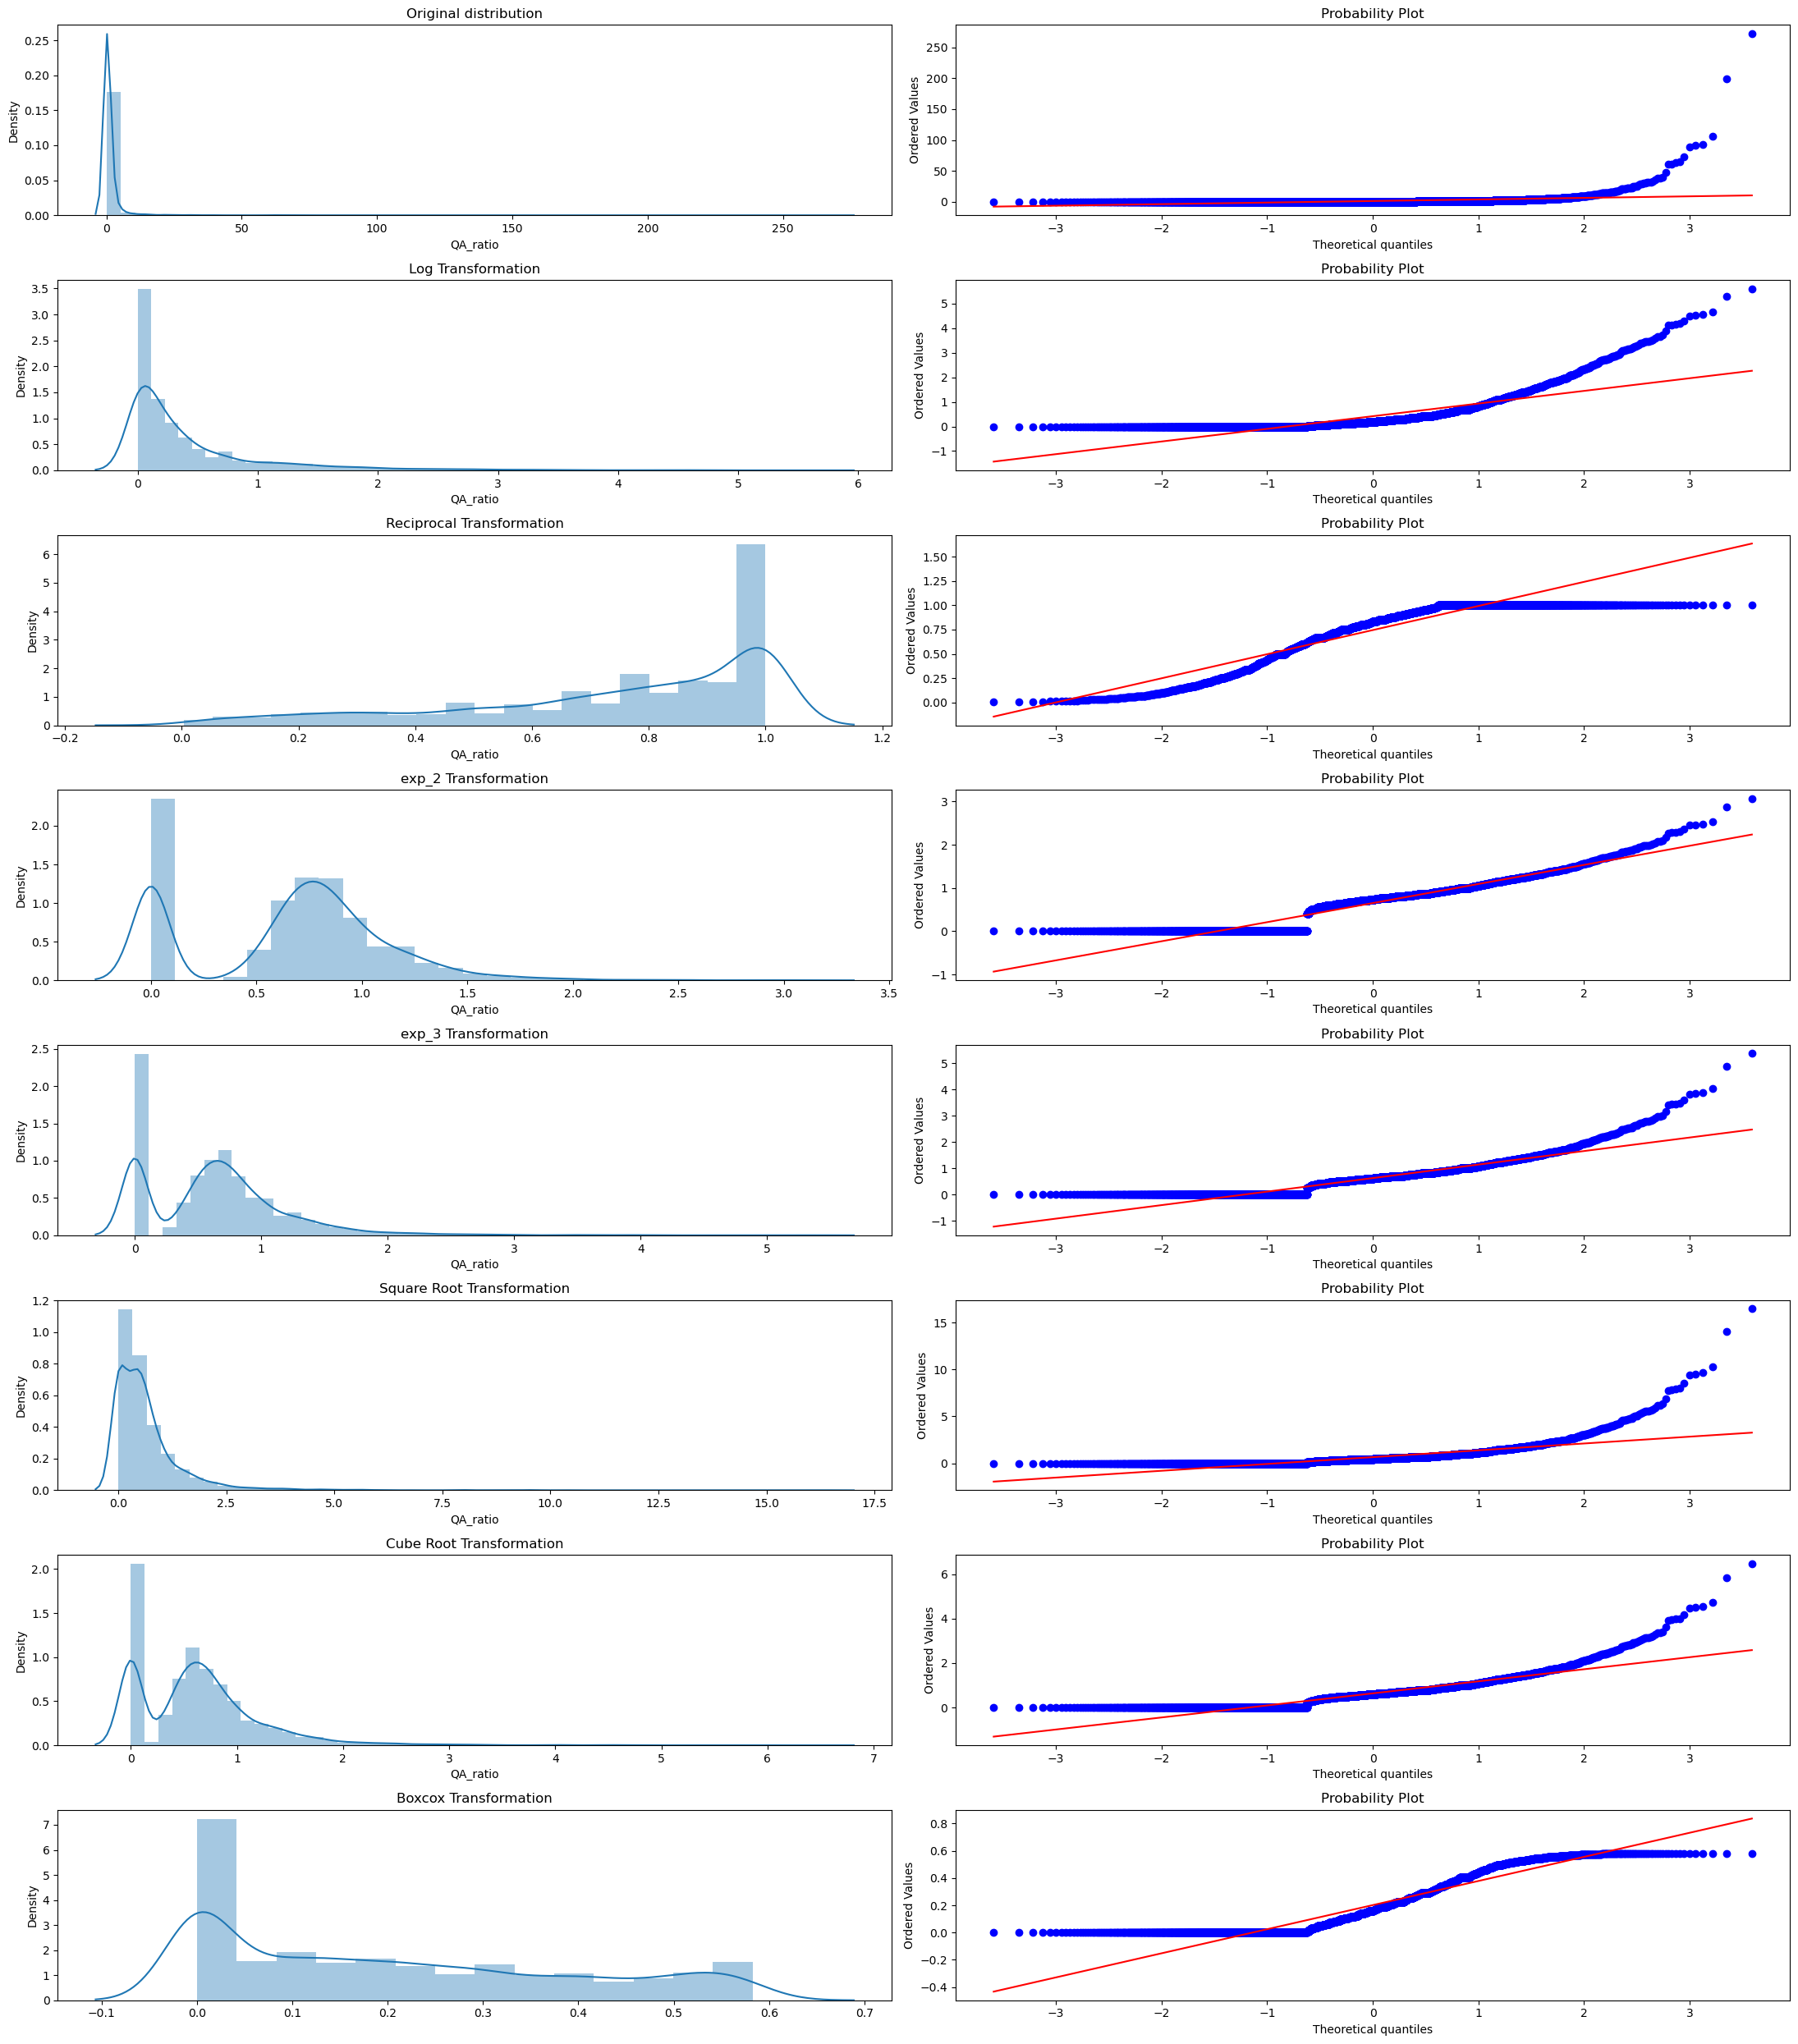

In [15]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [16]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
df_train['answers_st'],ans = st.boxcox(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],helpf = st.boxcox(df_train['helpful_tags']+1)
df_train['votes_cast_st'],vote = st.boxcox(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [17]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [19]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  15.252499
1                        reached_st  11.730043
2                      questions_st   7.430077
3                        answers_st  13.265130
4                   posts_edited_st   2.865633
5                   helpful_tags_st   2.353351
6                     votes_cast_st   5.625481
7           weighted_badge_score_st  11.687437
8                       QA_ratio_st   6.791173
9         member_since_in_months_st   2.870732
10  total_requirements_satisfied_st   1.112495

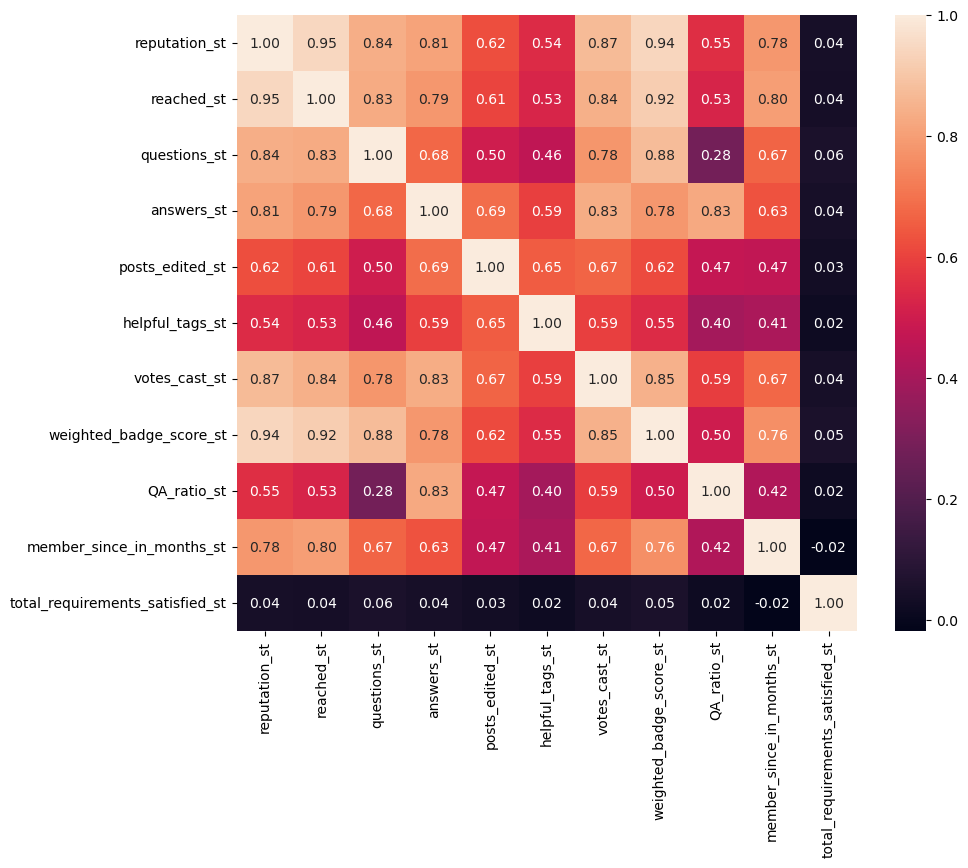

In [20]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

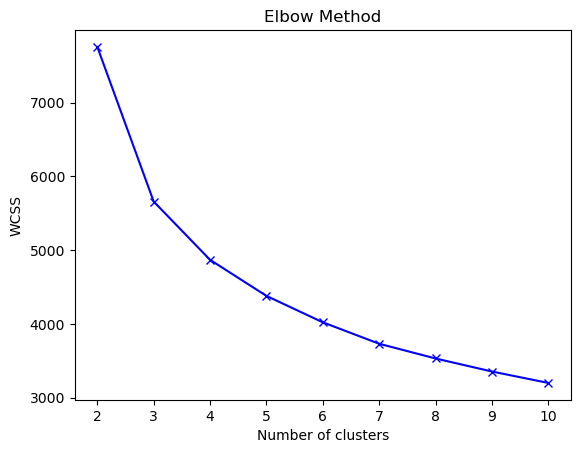

In [21]:
kmodel = df_train.copy()
wcss = []
results = []

for i in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  
    wcss.append(kmeans.inertia_)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(2, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
elbow_data

Number of Clusters         WCSS
0                   2  7756.898622
1                   3  5658.996252
2                   4  4868.638691
3                   5  4379.386534
4                   6  4021.149877
5                   7  3730.249992
6                   8  3530.413512
7                   9  3353.726051
8                  10  3198.797460

In [24]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [25]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0           1968.22   330642.18      55.71    14.03          0.19   
1             10.52      704.80       2.74     0.25          0.00   
2          16296.79  2946598.29     152.31   140.56         78.29   
3            139.65    22111.49       9.90     3.48          0.19   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.50      147.24                  112.94   
1                0.01        0.31                   23.17   
2               92.89     1320.80                  134.23   
3                0.10       19.57                   65.40   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       83.60      0.74                          2.19  
1                        6.26      0.13                          2.17  
2                      305.38      3.64                          2.23  
3                       21.00      0.83                          2.20

In [26]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        3              1279
1        0              1062
2        2               936
3        1               906

## Visualizing Clusters

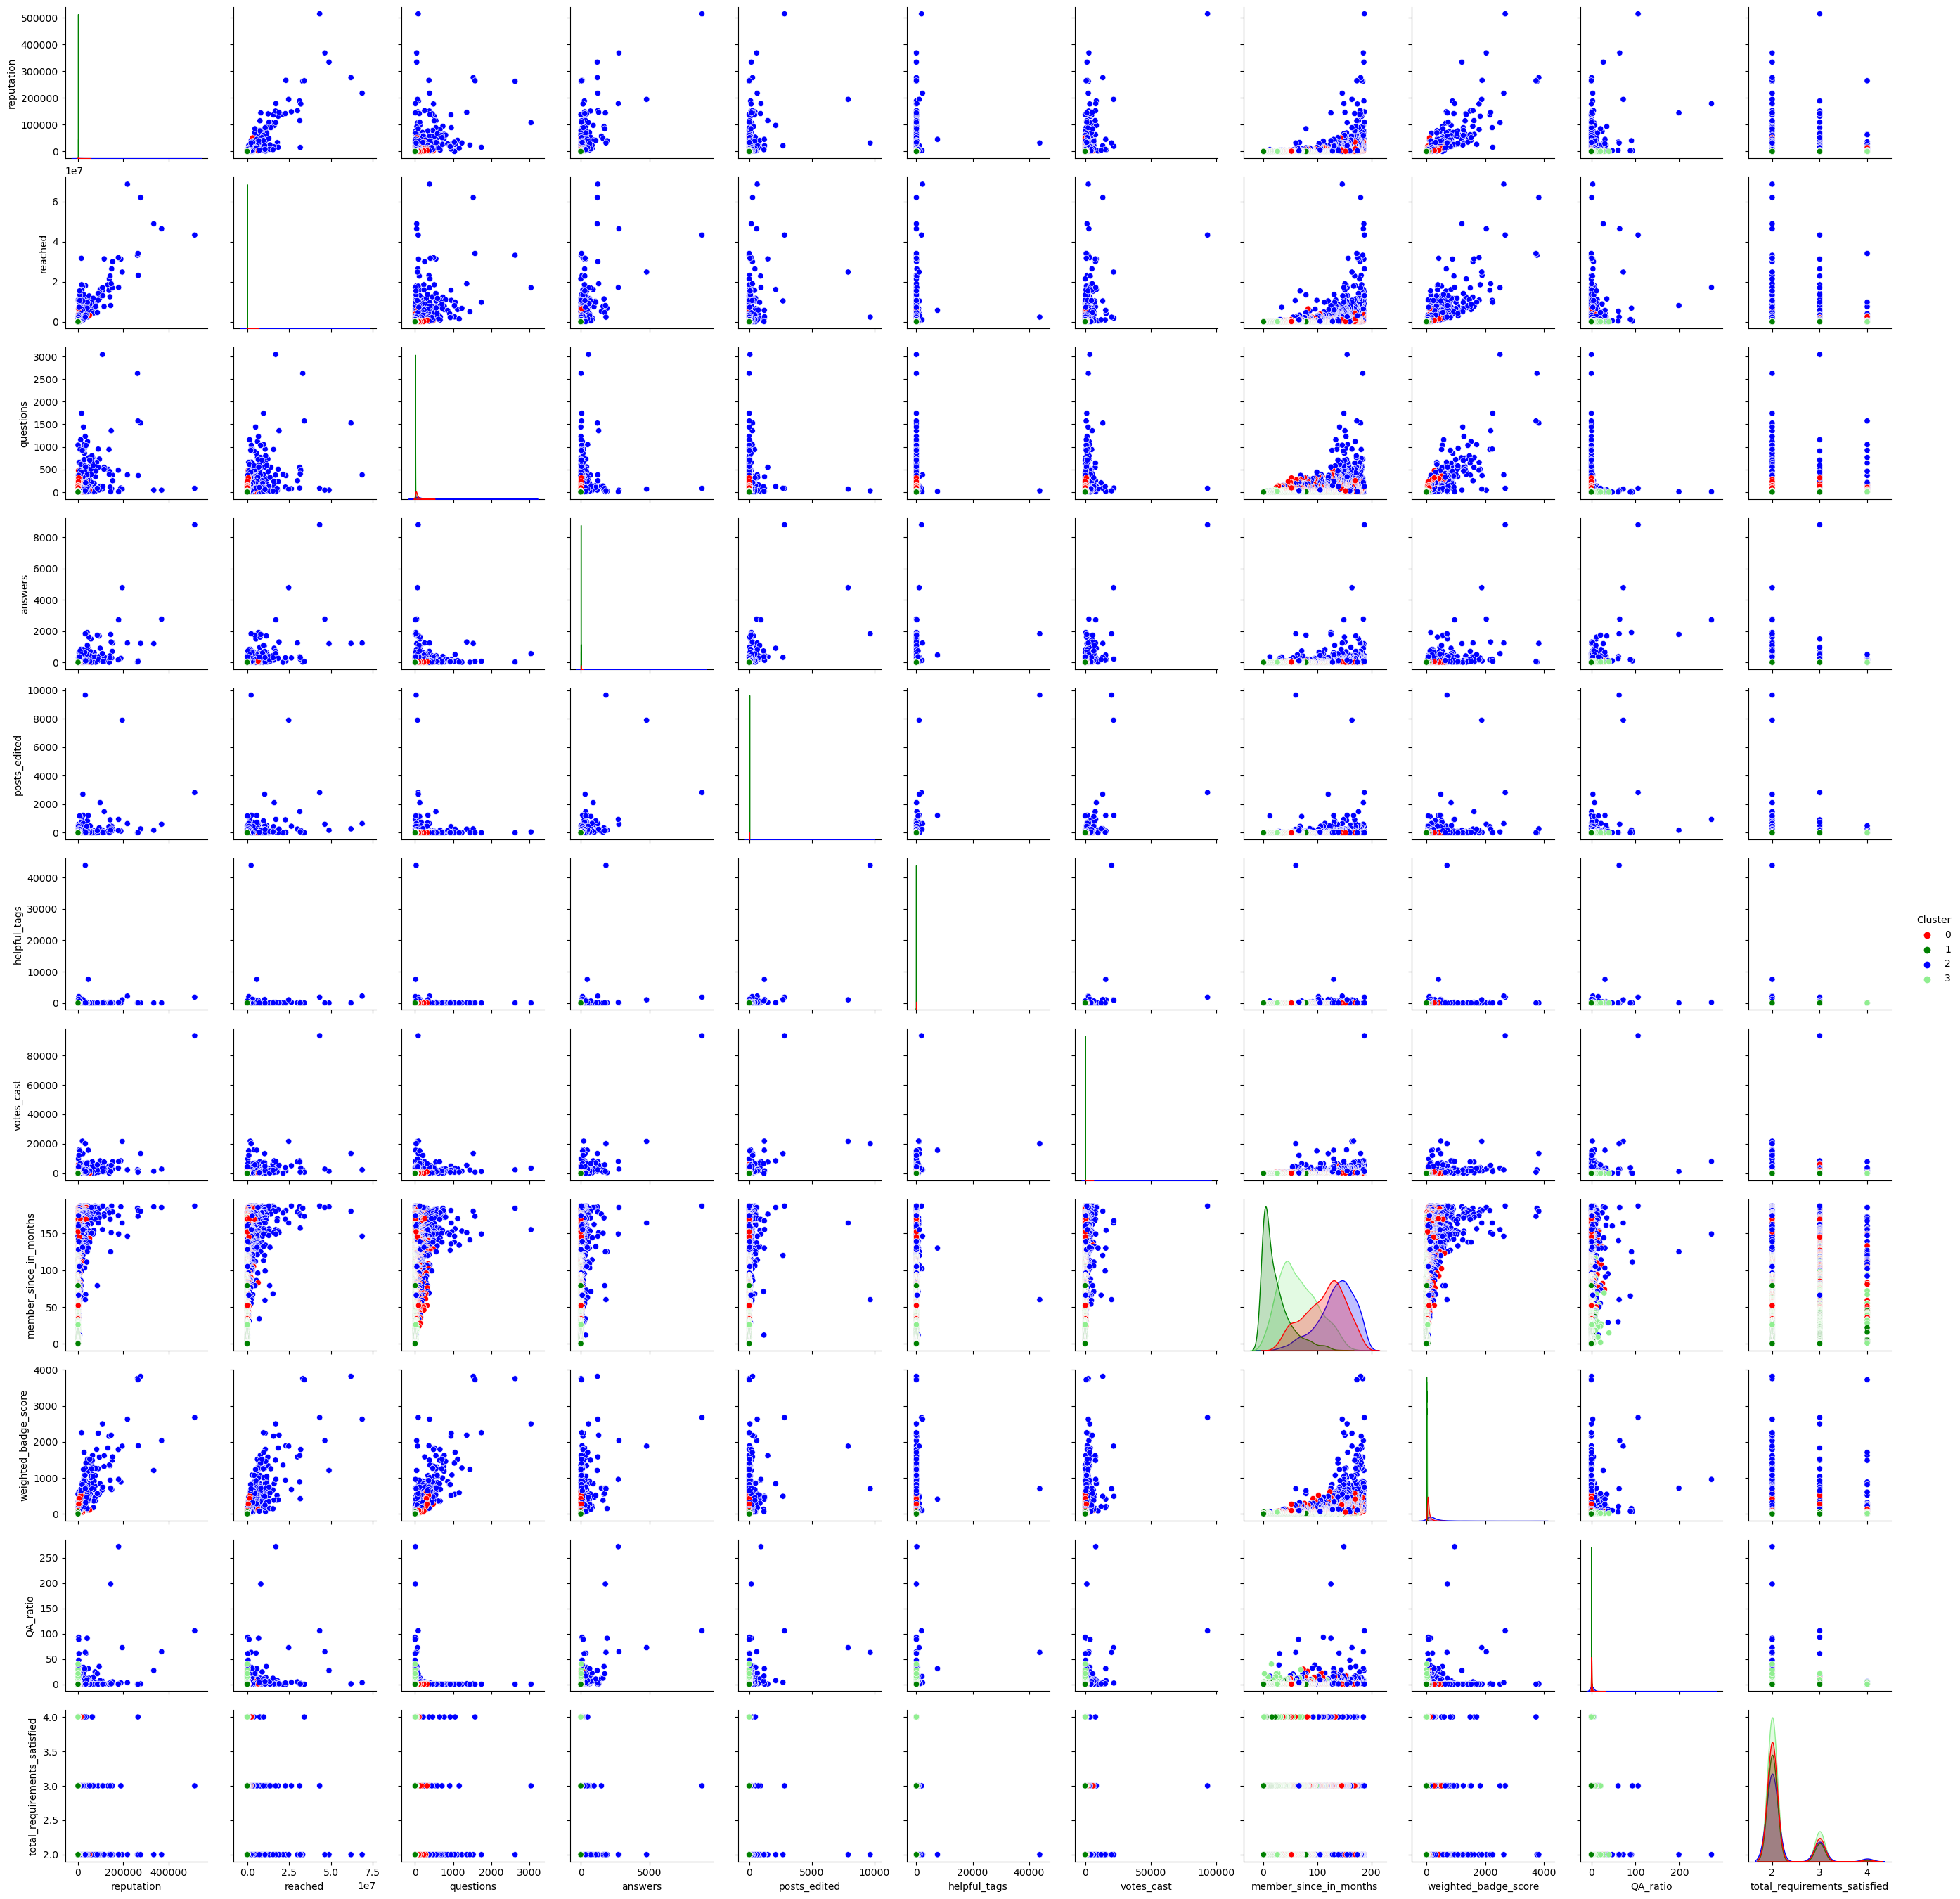

In [27]:
import seaborn as sns
palette = {0: "red", 1: "green", 2: "blue", 3: "lightgreen"} 
sns.pairplot(kmodel_inference, hue='Cluster', palette = palette)
plt.show()

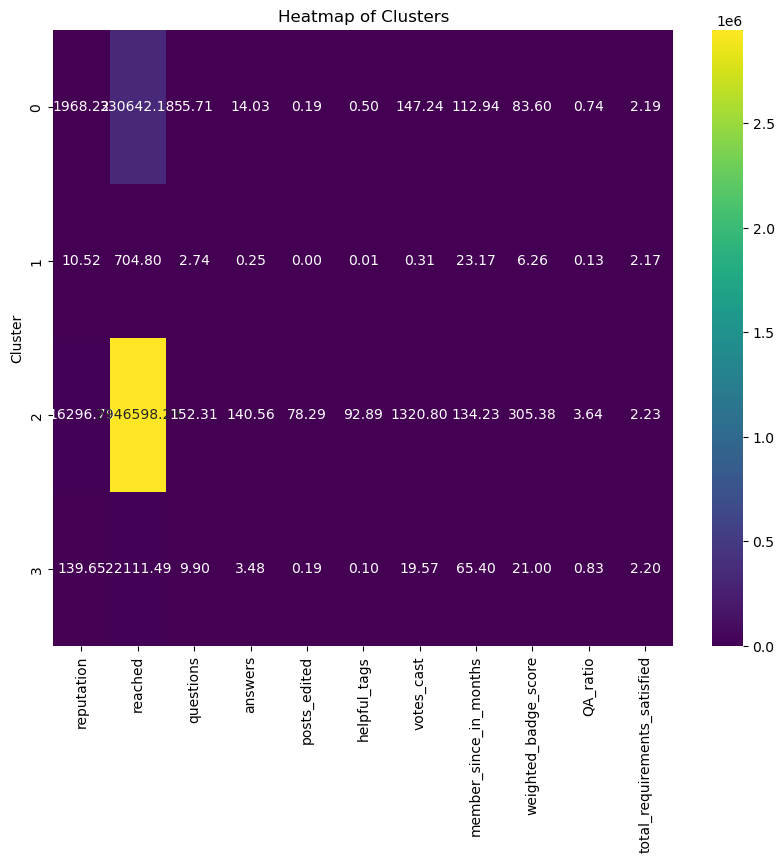

In [28]:
corr_matrix = kmodel_inference.groupby('Cluster').mean().round(2)
corr_matrix.sort_values(by='Cluster',inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap = 'viridis')
plt.title('Heatmap of Clusters')
plt.show()

## TESTING

In [29]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['Programming_Language_Flag'] = np.where(df_test['tags'].str.contains('python'),1,0)
df_test['Web_Framework_Flag'] = np.where(df_test['tags'].str.contains('django|flask|fastapi|pyramid|tornado'),1,0)
df_test['DBMS_Flag'] = np.where(df_test['tags'].str.contains('sql'),1,0)
df_test['FrontEnd_Flag'] = np.where(df_test['tags'].str.contains('html|css|javascript|.js|react|angular'),1,0)
df_test['Programming_Language_Flag'] = np.where(df_test['Web_Framework_Flag']==1, 1, df_test['Programming_Language_Flag'])
df_test['total_requirements_satisfied'] = df_test['Programming_Language_Flag']+df_test['Web_Framework_Flag']+df_test['DBMS_Flag']+df_test['FrontEnd_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[df_test['total_requirements_satisfied']>=2]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'],ans = st.boxcox(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],helpf = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'],vote = st.boxcox(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [30]:
testing_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0           2245.78   395655.52      63.28    16.46          0.26   
1             11.58      773.81       2.99     0.27          0.00   
2          17518.09  3041114.29     140.02   176.93        105.11   
3            176.43    34896.02      11.46     2.89          0.26   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.45      167.06                  118.74   
1                0.02        0.51                   23.57   
2               54.51     1312.27                  135.75   
3                0.20       23.84                   68.96   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       92.88      0.79                          2.21  
1                        7.13      0.13                          2.20  
2                      298.77      3.66                          2.19  
3                       22.15      0.65                          2.21

In [31]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        3               419
1        0               299
2        2               280
3        1               248

## Validation

In [32]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.26393590015745255


In [33]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'python-web-developer-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/python-web-developer-model.pkl
